In [2]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,   # <-- acá está el import que falta
    r2_score          # <-- y este también
)

C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\Usuario\anaconda3\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [4]:
# --- Rutas de los archivos ---

jpv_2024 = pd.read_excel(r"C:\Users\Usuario\OneDrive - Universidad de Montevideo\Archivos de SOSA MUSSE Augusto - Tésis - Latitud\Secado Latitud - UM - Editable\_consolidados\_salidas_calibradas\JPV_2024_calibrado.xlsx")
jpv_2025 = pd.read_excel(r"C:\Users\Usuario\OneDrive - Universidad de Montevideo\Archivos de SOSA MUSSE Augusto - Tésis - Latitud\Secado Latitud - UM - Editable\_consolidados\_salidas_calibradas\JPV_2025_calibrado.xlsx")
rb_2024  = pd.read_excel(r"C:\Users\Usuario\OneDrive - Universidad de Montevideo\Archivos de SOSA MUSSE Augusto - Tésis - Latitud\Secado Latitud - UM - Editable\_consolidados\_salidas_calibradas\RB_2024_calibrado.xlsx")
rb_2025  = pd.read_excel(r"C:\Users\Usuario\OneDrive - Universidad de Montevideo\Archivos de SOSA MUSSE Augusto - Tésis - Latitud\Secado Latitud - UM - Editable\_consolidados\_salidas_calibradas\RB_2025_calibrado.xlsx")

# Preprocesamiento general

In [5]:
# --- JPV 2024 ---
# Todas las SLI9193 de JPV 2024 están en descarte
jpv_2024 = jpv_2024[~jpv_2024["Variedad"].isin(["SLI9193"])]

# --- JPV 2024 y 2025 ---
# INOV no está en curvas de calibración en ninguna JPV
jpv_2024 = jpv_2024[~jpv_2024["Variedad"].isin(["INOV"])]
jpv_2025 = jpv_2025[~jpv_2025["Variedad"].isin(["INOV"])]

# --- RB 2024 ---
# CL1294 no está en curvas de calibración de RB 2024
rb_2024 = rb_2024[~rb_2024["Variedad"].isin(["CL1294"])]

# --- RB 2025 ---
# XP 117 no está en curvas de calibración de RB 2025
rb_2025 = rb_2025[~rb_2025["Variedad"].isin(["XP 117"])]

In [6]:
# --- Concatenar los cuatro DataFrames ---
df = pd.concat(
    [jpv_2024, jpv_2025, rb_2024, rb_2025],
    ignore_index=True
)

# --- Confirmar el resultado ---
print("✅ DataFrame combinado correctamente.")
print(f"Forma final: {df.shape}")
print("Columnas:", list(df.columns))

# --- Ver una muestra ---
df.head()
# Dropear filas sin valor en Variedad
df = df.dropna(subset=["Variedad"])

# Reemplazar L5903 por MERÍN
df["Variedad"] = df["Variedad"].replace("L5903", "MERÍN")

✅ DataFrame combinado correctamente.
Forma final: (197702, 12)
Columnas: ['planta', 'año', 'tirada_fecha', 'sensor_id', 'timestamp', 'VOLT_HUM', 'VOLT_TEM', 'Variedad', 'ID_tachada', 'DESCARTAR', 'HUMEDAD', 'TEMPERATURA']


In [7]:
# --- Concatenar los cuatro DataFrames ---
df = pd.concat(
    [jpv_2024, jpv_2025, rb_2024, rb_2025],
    ignore_index=True
)

# --- Confirmar el resultado ---
print("✅ DataFrame combinado correctamente.")
print(f"Forma final: {df.shape}")
print("Columnas:", list(df.columns))

# --- Ver una muestra ---
df.head()

✅ DataFrame combinado correctamente.
Forma final: (197702, 12)
Columnas: ['planta', 'año', 'tirada_fecha', 'sensor_id', 'timestamp', 'VOLT_HUM', 'VOLT_TEM', 'Variedad', 'ID_tachada', 'DESCARTAR', 'HUMEDAD', 'TEMPERATURA']


,planta,año,tirada_fecha,sensor_id,timestamp,VOLT_HUM,VOLT_TEM,Variedad,ID_tachada,DESCARTAR,HUMEDAD,TEMPERATURA
0,JPV,2024,2024-03-25,2,2024-03-19 09:13:57,0.0,0.0,GURÍ,20042,1,NaN,NaN
1,JPV,2024,2024-03-25,2,2024-03-19 09:18:57,0.0,0.0,GURÍ,20042,1,NaN,NaN
2,JPV,2024,2024-03-25,2,2024-03-19 09:23:57,0.0,0.0,GURÍ,20042,1,NaN,NaN
3,JPV,2024,2024-03-25,2,2024-03-19 09:28:57,0.0,0.0,GURÍ,20042,1,NaN,NaN
4,JPV,2024,2024-03-25,2,2024-03-19 09:33:57,0.0,0.0,GURÍ,20042,1,NaN,NaN


In [8]:
n_tachadas = df["ID_tachada"].nunique()
print(f"🔸 Cantidad de tachadas únicas en todo el DataFrame: {n_tachadas}")

tachadas_por_planta = df.groupby("planta")["ID_tachada"].nunique()
tachadas_por_anio = df.groupby("año")["ID_tachada"].nunique()

print("\n📊 Tachadas únicas por planta:")
print(tachadas_por_planta)

print("\n📊 Tachadas únicas por año:")
print(tachadas_por_anio)

🔸 Cantidad de tachadas únicas en todo el DataFrame: 1502

📊 Tachadas únicas por planta:
planta
JPV    885
RB     618
Name: ID_tachada, dtype: int64

📊 Tachadas únicas por año:
año
2024    612
2025    892
Name: ID_tachada, dtype: int64


In [9]:
#Ver como se distribuye el target
df['DESCARTAR'].value_counts()

DESCARTAR
0    150840
1     46862
Name: count, dtype: int64

In [10]:
#Ver cantidad de valores faltantes del target
df['DESCARTAR'].isnull().sum()

0

# Análisis Exploratorio #

In [32]:
df.head()

,planta,año,tirada_fecha,sensor_id,timestamp,VOLT_HUM,VOLT_TEM,Variedad,ID_tachada,DESCARTAR,HUMEDAD,TEMPERATURA
0,JPV,2024,2024-03-25,2,2024-03-19 09:13:57,0.0,0.0,GURÍ,20042,1,NaN,NaN
1,JPV,2024,2024-03-25,2,2024-03-19 09:18:57,0.0,0.0,GURÍ,20042,1,NaN,NaN
2,JPV,2024,2024-03-25,2,2024-03-19 09:23:57,0.0,0.0,GURÍ,20042,1,NaN,NaN
3,JPV,2024,2024-03-25,2,2024-03-19 09:28:57,0.0,0.0,GURÍ,20042,1,NaN,NaN
4,JPV,2024,2024-03-25,2,2024-03-19 09:33:57,0.0,0.0,GURÍ,20042,1,NaN,NaN


In [55]:
df["ID_tachada"].nunique()

1502

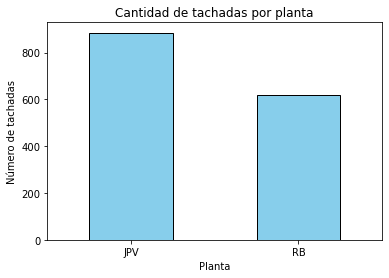

In [33]:


# Agrupar por tachada para obtener una fila por ID_tachada
df_tach = df.groupby("ID_tachada").agg({
    "planta": "first"
}).reset_index()

# Conteo por planta
conteo = df_tach["planta"].value_counts()

plt.figure(figsize=(6,4))
conteo.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Cantidad de tachadas por planta")
plt.xlabel("Planta")
plt.ylabel("Número de tachadas")
plt.xticks(rotation=0)

plt.show()

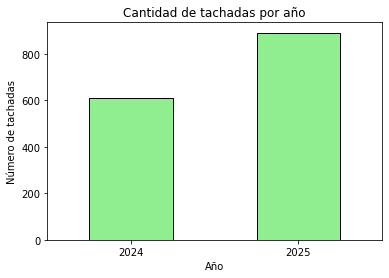

In [34]:


# Agrupar por tachada para obtener una fila por ID_tachada
df_tach = df.groupby("ID_tachada").agg({
    "año": "first"
}).reset_index()

# Conteo por año
conteo = df_tach["año"].value_counts().sort_index()

plt.figure(figsize=(6,4))
conteo.plot(kind="bar", color="lightgreen", edgecolor="black")

plt.title("Cantidad de tachadas por año")
plt.xlabel("Año")
plt.ylabel("Número de tachadas")
plt.xticks(rotation=0)

plt.show()

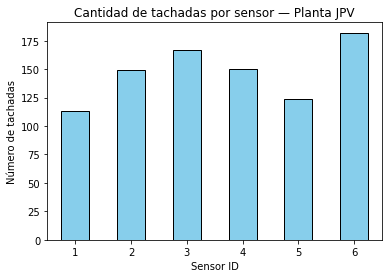

In [35]:


# Agrupar por tachada y quedarnos solo con planta y sensor
df_tach = df.groupby("ID_tachada").agg({
    "planta": "first",
    "sensor_id": "first"
}).reset_index()

# Filtrar JPV
df_jpv = df_tach[df_tach["planta"] == "JPV"]

conteo_jpv = df_jpv["sensor_id"].value_counts().sort_index()

plt.figure(figsize=(6,4))
conteo_jpv.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Cantidad de tachadas por sensor — Planta JPV")
plt.xlabel("Sensor ID")
plt.ylabel("Número de tachadas")
plt.xticks(rotation=0)

plt.show()

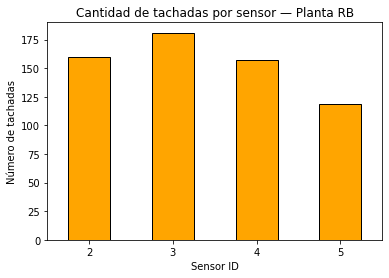

In [36]:
# Filtrar RB
df_rb = df_tach[df_tach["planta"] == "RB"]

conteo_rb = df_rb["sensor_id"].value_counts().sort_index()

plt.figure(figsize=(6,4))
conteo_rb.plot(kind="bar", color="orange", edgecolor="black")

plt.title("Cantidad de tachadas por sensor — Planta RB")
plt.xlabel("Sensor ID")
plt.ylabel("Número de tachadas")
plt.xticks(rotation=0)

plt.show()

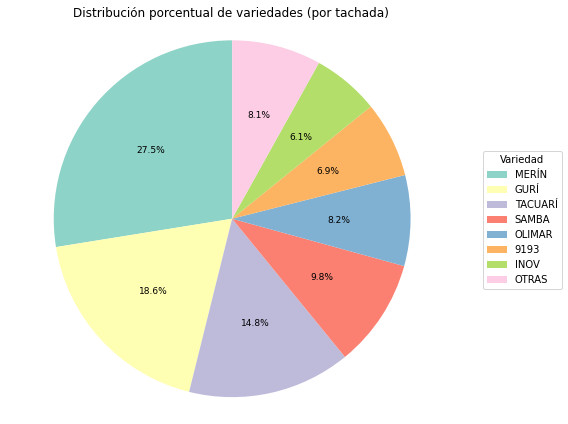

In [39]:


# Agrupar por tachada y tomar la primera variedad de cada una
df_tach = df.groupby("ID_tachada").agg({
    "Variedad": "first"
}).reset_index()

# Conteo de variedades
conteo_var = df_tach["Variedad"].value_counts(normalize=True) * 100

# Agrupar variedades con menos de 5%
var_mayores = conteo_var[conteo_var >= 5]
var_otras = conteo_var[conteo_var < 5].sum()

# Crear nueva serie con "OTRAS"
conteo_agrupado = var_mayores.copy()
if var_otras > 0:
    conteo_agrupado["OTRAS"] = var_otras

# Convertir a frecuencias absolutas (para pie chart)
conteo_abs = (conteo_agrupado / 100 * len(df_tach)).astype(int)

# Pie chart
plt.figure(figsize=(8, 6))
colores = plt.cm.Set3.colors

patches, texts, autotexts = plt.pie(
    conteo_abs,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    colors=colores
)

for autotext in autotexts:
    autotext.set_fontsize(9)

# Leyenda externa
plt.legend(
    patches,
    conteo_agrupado.index,
    title="Variedad",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left"
)

plt.title("Distribución porcentual de variedades (por tachada)")
plt.axis("equal")
plt.tight_layout()
plt.show()

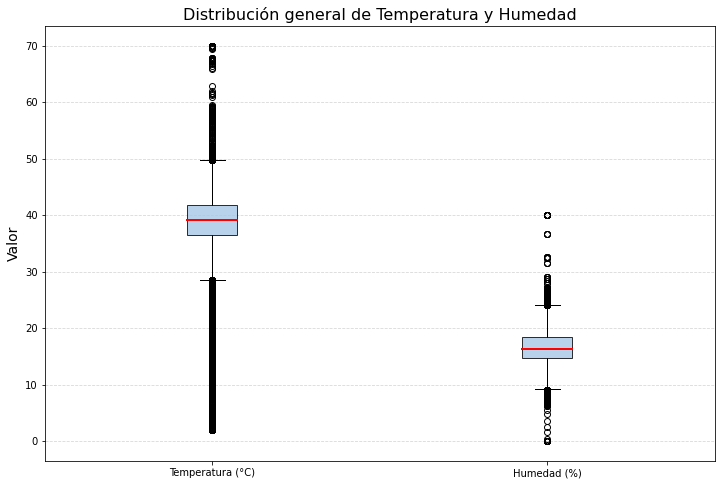

In [57]:

plt.figure(figsize=(12, 8))

# Limitar valores extremos solo para visualización (no afecta datos originales)
temp = df["TEMPERATURA"].clip(lower=0, upper=70)   # limites razonables
hum  = df["HUMEDAD"].clip(lower=0, upper=40)

plt.boxplot(
    [temp.dropna(), hum.dropna()],
    labels=["Temperatura (°C)", "Humedad (%)"],
    patch_artist=True,
    boxprops=dict(facecolor="#A7C7E7", alpha=0.8),
    medianprops=dict(color="red", linewidth=2),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black")
)

plt.title("Distribución general de Temperatura y Humedad", fontsize=16)
plt.ylabel("Valor", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


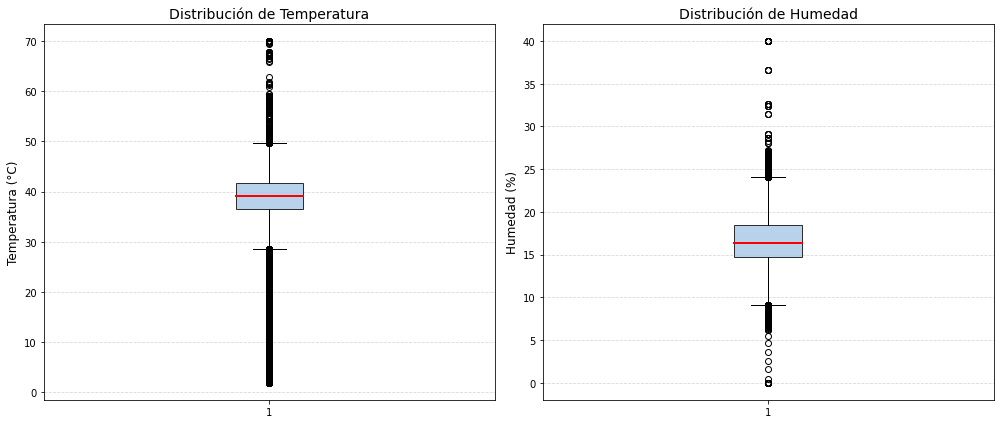

In [58]:
import matplotlib.pyplot as plt

# Limitar valores extremos solo para visualización
temp = df["TEMPERATURA"].clip(lower=0, upper=70)
hum  = df["HUMEDAD"].clip(lower=0, upper=40)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Boxplot Temperatura ---
axes[0].boxplot(
    temp.dropna(),
    patch_artist=True,
    boxprops=dict(facecolor="#A7C7E7", alpha=0.8),
    medianprops=dict(color="red", linewidth=2),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black")
)
axes[0].set_title("Distribución de Temperatura", fontsize=14)
axes[0].set_ylabel("Temperatura (°C)", fontsize=12)
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

# --- Boxplot Humedad ---
axes[1].boxplot(
    hum.dropna(),
    patch_artist=True,
    boxprops=dict(facecolor="#A7C7E7", alpha=0.8),
    medianprops=dict(color="red", linewidth=2),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black")
)
axes[1].set_title("Distribución de Humedad", fontsize=14)
axes[1].set_ylabel("Humedad (%)", fontsize=12)
axes[1].grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

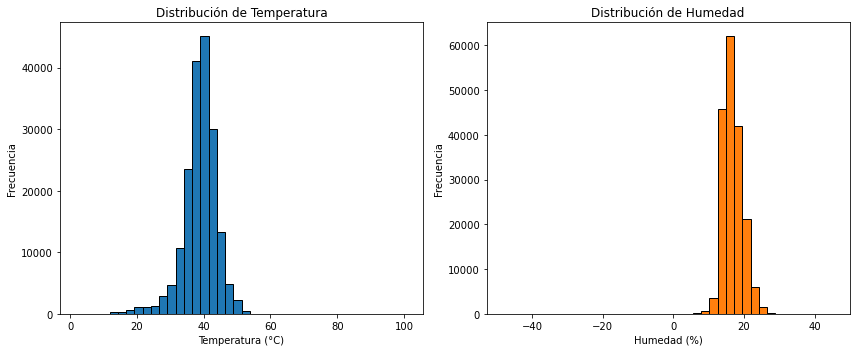

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Histograma Temperatura
plt.subplot(1,2,1)
plt.hist(df["TEMPERATURA"].dropna(), bins=40, color="#1f77b4", edgecolor="black")
plt.title("Distribución de Temperatura")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Frecuencia")

# Histograma Humedad
plt.subplot(1,2,2)
plt.hist(df["HUMEDAD"].dropna(), bins=40, color="#ff7f0e", edgecolor="black")
plt.title("Distribución de Humedad")
plt.xlabel("Humedad (%)")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

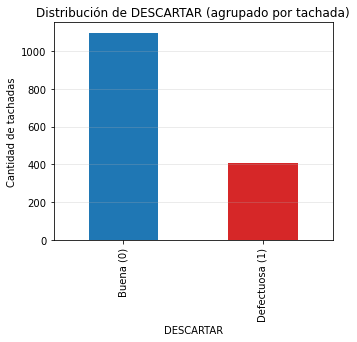

In [52]:


# Agrupar por tachada y tomar el valor único del target
df_tach = df.groupby("ID_tachada")["DESCARTAR"].first().reset_index()

plt.figure(figsize=(5,4))
df_tach["DESCARTAR"].value_counts().sort_index().plot(
    kind="bar",
    color=["#1f77b4", "#d62728"]
)

plt.xticks([0,1], ["Buena (0)", "Defectuosa (1)"])
plt.ylabel("Cantidad de tachadas")
plt.title("Distribución de DESCARTAR (agrupado por tachada)")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Modelo Baseline

In [11]:
# Se corre un modelo Catboost simple, sin preprocesamiento para marcar un BASELINE, y a partir de las métricas arrojadas, buscar
# mejorar el modelo a partir de cambios en los datos, y otros tipos de modelados. 

X = df.drop(columns=["DESCARTAR"])
y = df["DESCARTAR"]
groups = df["ID_tachada"]

# Split sin data leakage (por ID_tachada)

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Limpiar categóricas mínimamente

cat_cols = ["planta", "Variedad"]

for col in cat_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    X_train[col] = X_train[col].replace(["nan", "NaT", "None", " ", ""], "Desconocido")
    X_test[col] = X_test[col].replace(["nan", "NaT", "None", " ", ""], "Desconocido")

In [12]:
modelo_base = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    cat_features=cat_cols,
    eval_metric="F1",
    verbose=0,
    random_seed=42
)

modelo_base.fit(X_train, y_train)

# Predicciones

y_pred = modelo_base.predict(X_test)
y_pred_proba = modelo_base.predict_proba(X_test)[:, 1]

📊 Métricas:
Precision: 0.769
Recall:    0.616
F1-score:  0.684


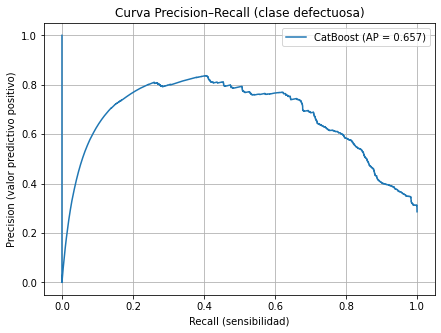

In [13]:
# Métricas clase defectuosa (1)

reporte = classification_report(y_test, y_pred, output_dict=True)
precision_def = reporte["1"]["precision"]
recall_def = reporte["1"]["recall"]
f1_def = reporte["1"]["f1-score"]

print("📊 Métricas:")
print(f"Precision: {precision_def:.3f}")
print(f"Recall:    {recall_def:.3f}")
print(f"F1-score:  {f1_def:.3f}")

# Curva Precision–Recall

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_prec = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"CatBoost (AP = {avg_prec:.3f})")
plt.xlabel("Recall (sensibilidad)")
plt.ylabel("Precision (valor predictivo positivo)")
plt.title("Curva Precision–Recall (clase defectuosa)")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#Partimos de estas métricas. Se irán probando distintos modelos, técnicas y preprocesamientos de datos en busca de mejorarlas,
#principalmente el recall, pero sin descuidar el precision. 

# Modelos agrupados por tachadas

In [15]:
#  Split por ID_tachada (sin data leakage)
X = df.drop(columns=["DESCARTAR"])
y = df["DESCARTAR"]
groups = df["ID_tachada"]

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

df_train = df.iloc[train_idx].copy()
df_test = df.iloc[test_idx].copy()

print(f"Tachadas únicas en TRAIN: {df_train['ID_tachada'].nunique()}")
print(f"Tachadas únicas en TEST:  {df_test['ID_tachada'].nunique()}")
print(f"Total de tachadas únicas: {df['ID_tachada'].nunique()}")

Tachadas únicas en TRAIN: 1201
Tachadas únicas en TEST:  301
Total de tachadas únicas: 1502


In [15]:
def resumir_tachadas(df):
    df = df.sort_values(["ID_tachada", "timestamp"])

    resumen = df.groupby("ID_tachada").agg(
        humedad_mean=("HUMEDAD", "mean"),
        humedad_std=("HUMEDAD", "std"),
        humedad_min=("HUMEDAD", "min"),
        humedad_max=("HUMEDAD", "max"),
        temp_mean=("TEMPERATURA", "mean"),
        temp_std=("TEMPERATURA", "std"),
        temp_min=("TEMPERATURA", "min"),
        temp_max=("TEMPERATURA", "max"),
        timestamp_min=("timestamp", "min"),
        timestamp_max=("timestamp", "max"),
        variedad=("Variedad", "first"),
        planta=("planta", "first"),
        sensor_id=("sensor_id", "first"),
        año=("año", "first"),
        descartar=("DESCARTAR", "first")
    ).reset_index()

    # Rango
    resumen["humedad_range"] = resumen["humedad_max"] - resumen["humedad_min"]
    resumen["temp_range"] = resumen["temp_max"] - resumen["temp_min"]

    # Percentiles
    resumen["humedad_p25"] = df.groupby("ID_tachada")["HUMEDAD"].quantile(0.25).values
    resumen["humedad_p75"] = df.groupby("ID_tachada")["HUMEDAD"].quantile(0.75).values
    resumen["temp_p25"] = df.groupby("ID_tachada")["TEMPERATURA"].quantile(0.25).values
    resumen["temp_p75"] = df.groupby("ID_tachada")["TEMPERATURA"].quantile(0.75).values

    # Duración total de la tachada (horas)
    resumen["duracion_horas"] = (resumen["timestamp_max"] - resumen["timestamp_min"]).dt.total_seconds() / 3600

    # Momento del día
    resumen["hora_inicio"] = resumen["timestamp_min"].dt.hour
    condiciones = [
        resumen["hora_inicio"].between(6, 12),
        resumen["hora_inicio"].between(12, 18),
        resumen["hora_inicio"].between(18, 24),
        resumen["hora_inicio"].between(0, 6)
    ]
    categorias = ["mañana", "tarde", "noche", "madrugada"]
    resumen["momento_dia"] = np.select(condiciones, categorias, default="desconocido")

    # Slope: tendencia de temperatura y humedad
    def slope(grupo, col):
        if len(grupo) > 1:
            return (grupo[col].iloc[-1] - grupo[col].iloc[0]) / (
                (grupo["timestamp"].iloc[-1] - grupo["timestamp"].iloc[0]).total_seconds() + 1e-9
            )
        else:
            return 0

    resumen["slope_temp"] = df.groupby("ID_tachada").apply(slope, "TEMPERATURA").values
    resumen["slope_hum"] = df.groupby("ID_tachada").apply(slope, "HUMEDAD").values

    return resumen



In [23]:
resumen_train = resumir_tachadas(df_train)
resumen_test = resumir_tachadas(df_test)

print("✅ Datos resumidos por tachada")
print(f"Train shape: {resumen_train.shape}")
print(f"Test shape:  {resumen_test.shape}")

C:\Users\Usuario\AppData\Local\Temp/ipykernel_22932/1915019031.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen["slope_temp"] = df.groupby("ID_tachada").apply(slope, "TEMPERATURA").values
C:\Users\Usuario\AppData\Local\Temp/ipykernel_22932/1915019031.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen["slope_hum"] = df.groupby("ID_tachada").apply(slope, "HUMEDAD").values


✅ Datos resumidos por tachada
Train shape: (1201, 27)
Test shape:  (301, 27)


C:\Users\Usuario\AppData\Local\Temp/ipykernel_22932/1915019031.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen["slope_temp"] = df.groupby("ID_tachada").apply(slope, "TEMPERATURA").values
C:\Users\Usuario\AppData\Local\Temp/ipykernel_22932/1915019031.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen["slope_hum"] = df.groupby("ID_tachada").apply(slope, "HUMEDAD").values


In [24]:
resumen_test.head()

,ID_tachada,humedad_mean,humedad_std,humedad_min,humedad_max,temp_mean,temp_std,temp_min,temp_max,timestamp_min,...,temp_range,humedad_p25,humedad_p75,temp_p25,temp_p75,duracion_horas,hora_inicio,momento_dia,slope_temp,slope_hum
0,18608,16.383725,2.589520,12.171289,20.770967,38.306248,2.067626,34.806759,43.137918,2025-03-15 08:33:48,...,8.331159,13.927401,18.720134,36.889548,39.877899,14.917500,8,mañana,0.000142,-0.000156
1,18617,17.505689,2.611235,12.956948,21.705882,40.797124,2.948665,36.094915,45.874972,2025-03-16 18:33:54,...,9.780057,15.258643,19.732261,38.268261,43.701626,13.417222,18,tarde,0.000202,-0.000175
2,18623,17.768757,2.754978,12.433167,21.736311,40.700989,3.119904,28.488205,47.535605,2025-03-17 08:33:56,...,19.047400,15.533106,20.197912,38.268261,42.826689,23.917778,8,mañana,NaN,NaN
3,18624,16.326243,2.111164,12.189742,22.009342,38.605262,3.111948,30.298454,44.787427,2025-03-17 00:33:55,...,14.488973,14.721314,18.007078,36.818492,40.440735,10.917222,0,madrugada,0.000074,0.000063
4,18626,14.654171,0.877857,13.456153,16.462459,40.708578,1.777351,34.987565,42.232051,2025-03-18 08:34:00,...,7.244486,13.894158,15.310793,40.420929,41.869827,5.583889,8,mañana,0.000306,-0.000136


In [25]:
resumen_train.columns.tolist()

['ID_tachada',
 'humedad_mean',
 'humedad_std',
 'humedad_min',
 'humedad_max',
 'temp_mean',
 'temp_std',
 'temp_min',
 'temp_max',
 'timestamp_min',
 'timestamp_max',
 'variedad',
 'planta',
 'sensor_id',
 'año',
 'descartar',
 'humedad_range',
 'temp_range',
 'humedad_p25',
 'humedad_p75',
 'temp_p25',
 'temp_p75',
 'duracion_horas',
 'hora_inicio',
 'momento_dia',
 'slope_temp',
 'slope_hum']

In [26]:
# Separar variables explicativas y target
X_train = resumen_train.drop(columns=["descartar"])
y_train = resumen_train["descartar"]

X_test = resumen_test.drop(columns=["descartar"])
y_test = resumen_test["descartar"]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1201, 26) (1201,)
(301, 26) (301,)


In [27]:
# Eliminar columnas innecesarias
cols_drop = ["ID_tachada", "planta", "año", "tirada_fecha", "timestamp_min", "timestamp_max"]
X_train = X_train.drop(columns=cols_drop, errors="ignore")
X_test = X_test.drop(columns=cols_drop, errors="ignore")

# Convertir sensor_id a string (evita interpretación ordinal)
X_train["sensor_id"] = X_train["sensor_id"].astype(str)
X_test["sensor_id"] = X_test["sensor_id"].astype(str)

# Definir columnas categóricas
cat_cols = ["variedad", "sensor_id", "momento_dia"]

# Convertir a tipo category
for col in cat_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

print("✅ Dataset listo para Modelar")
print(f"Variables categóricas: {cat_cols}")
print(f"Shape final X_train: {X_train.shape}")
print(f"Shape final X_test:  {X_test.shape}")

✅ Dataset listo para Modelar
Variables categóricas: ['variedad', 'sensor_id', 'momento_dia']
Shape final X_train: (1201, 21)
Shape final X_test:  (301, 21)


In [28]:
X_train["variedad"] = X_train["variedad"].fillna("MERÍN")
X_test["variedad"] = X_test["variedad"].fillna("MERÍN")

# Primer modelo Catboost

✅ Resultados CatBoost (clase defectuosa = 1, umbral = 0.2)

Precision: 0.879
Recall:    0.792
F1-score:  0.833


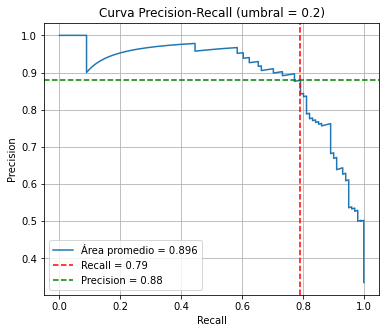

In [29]:
# Columnas categóricas
cat_cols = ["variedad", "sensor_id", "momento_dia"]

# Modelo CatBoost
modelo_cb = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    eval_metric="F1",
    random_seed=42,
    verbose=0
)

# Entrenamiento
modelo_cb.fit(X_train, y_train, cat_features=cat_cols)

# Probabilidades
y_prob = modelo_cb.predict_proba(X_test)[:, 1]


umbral = 0.20 


y_pred = (y_prob >= umbral).astype(int)

# Métricas clase defectuosa (1)
reporte = classification_report(y_test, y_pred, output_dict=True)
precision_1 = reporte['1']['precision']
recall_1 = reporte['1']['recall']
f1_1 = reporte['1']['f1-score']

print(f"✅ Resultados CatBoost (clase defectuosa = 1, umbral = {umbral})\n")
print(f"Precision: {precision_1:.3f}")
print(f"Recall:    {recall_1:.3f}")
print(f"F1-score:  {f1_1:.3f}")

# Curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"Área promedio = {ap:.3f}")
plt.axvline(x=recall_1, color="r", linestyle="--", label=f"Recall = {recall_1:.2f}")
plt.axhline(y=precision_1, color="g", linestyle="--", label=f"Precision = {precision_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (umbral = {umbral})")
plt.legend()
plt.grid(True)
plt.show()

# Segundo modelo Catboost

A diferencia del primero, se le agrega el parámetro class_weights que sirve para ponderar la clase defectuosa y así eliminar el problema de desequilibrio de clases. Vemos que funciona porque el recall aumenta

✅ Resultados CatBoost (clase defectuosa = 1, umbral = 0.2, peso = 2)

Precision: 0.835
Recall:    0.851
F1-score:  0.843


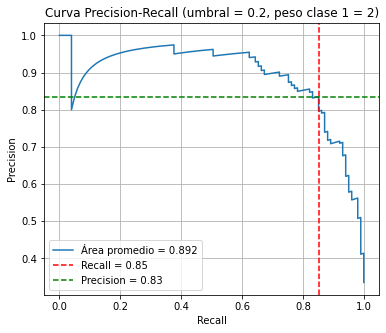

In [30]:
# Modelo CatBoost con class_weights y umbral ajustable
# ===============================

# Columnas categóricas
cat_cols = ["variedad", "sensor_id", "momento_dia"]

# Peso de la clase defectuosa (1)
peso_clase_defectuosa = 2   # 🔁 Cambiá este valor: >1 aumenta el peso de la clase minoritaria
class_weights = [1.0, peso_clase_defectuosa]

# Modelo CatBoost
modelo_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric="F1",
    random_seed=42,
    verbose=0,
    class_weights=class_weights
)

# Entrenamiento
modelo_cb.fit(X_train, y_train, cat_features=cat_cols)

# Probabilidades
y_prob = modelo_cb.predict_proba(X_test)[:, 1]


umbral = 0.20  


y_pred = (y_prob >= umbral).astype(int)

# Métricas clase defectuosa (1)
reporte = classification_report(y_test, y_pred, output_dict=True)
precision_1 = reporte['1']['precision']
recall_1 = reporte['1']['recall']
f1_1 = reporte['1']['f1-score']

print(f"✅ Resultados CatBoost (clase defectuosa = 1, umbral = {umbral}, peso = {peso_clase_defectuosa})\n")
print(f"Precision: {precision_1:.3f}")
print(f"Recall:    {recall_1:.3f}")
print(f"F1-score:  {f1_1:.3f}")

# Curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"Área promedio = {ap:.3f}")
plt.axvline(x=recall_1, color="r", linestyle="--", label=f"Recall = {recall_1:.2f}")
plt.axhline(y=precision_1, color="g", linestyle="--", label=f"Precision = {precision_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (umbral = {umbral}, peso clase 1 = {peso_clase_defectuosa})")
plt.legend()
plt.grid(True)
plt.show()

El modelo catboost con preprocesamiento, usando un umbral bajo y agregando class weight para el desequilibrio de clases (para que pondere de igual forma) arroja las mejores métricas hasta ahora. 

# Light GBM 

✅ Resultados LightGBM (clase defectuosa = 1, umbral = 0.25)

Precision: 0.874
Recall:    0.752
F1-score:  0.809


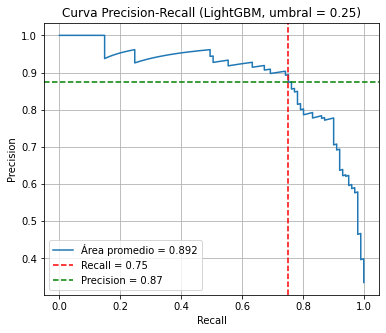

In [22]:
# Dataset para LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)


params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "random_state": 42,
    "verbose": -1,
    "scale_pos_weight": 2.0   
}

# Entrenamiento
modelo_lgb = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[test_data],
    num_boost_round=300
)

# Predicciones
y_prob = modelo_lgb.predict(X_test)
umbral = 0.25 # 🔁 Ajustá para ver trade-off
y_pred = (y_prob >= umbral).astype(int)

# Métricas clase defectuosa (1)
reporte = classification_report(y_test, y_pred, output_dict=True)
precision_1 = reporte['1']['precision']
recall_1 = reporte['1']['recall']
f1_1 = reporte['1']['f1-score']

print(f"✅ Resultados LightGBM (clase defectuosa = 1, umbral = {umbral})\n")
print(f"Precision: {precision_1:.3f}")
print(f"Recall:    {recall_1:.3f}")
print(f"F1-score:  {f1_1:.3f}")

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"Área promedio = {ap:.3f}")
plt.axvline(x=recall_1, color="r", linestyle="--", label=f"Recall = {recall_1:.2f}")
plt.axhline(y=precision_1, color="g", linestyle="--", label=f"Precision = {precision_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (LightGBM, umbral = {umbral})")
plt.legend()
plt.grid(True)
plt.show()

Vemos si algún scale pos weight maximiza el recall, pero no mejora el que arrojó el último catboost

In [23]:
for w in [1, 2, 3, 4, 5]:
    params["scale_pos_weight"] = w
    modelo = lgb.train(params, train_data, num_boost_round=300)
    y_pred = (modelo.predict(X_test) >= 0.25).astype(int)
    
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Peso={w} → Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f}")

Peso=1 → Precision=0.869 | Recall=0.723 | F1=0.789
Peso=2 → Precision=0.874 | Recall=0.752 | F1=0.809
Peso=3 → Precision=0.868 | Recall=0.782 | F1=0.823
Peso=4 → Precision=0.860 | Recall=0.733 | F1=0.791
Peso=5 → Precision=0.865 | Recall=0.762 | F1=0.811


Vemos que el modelo Lightgbm, aunque se ajusten parametros como el umbral o scale pos weight, tiende a dar altos precisions pero no tan altos recalls. Volvemos al catboost para ver la importancia de cada feature.

# Feature importance de Catboost

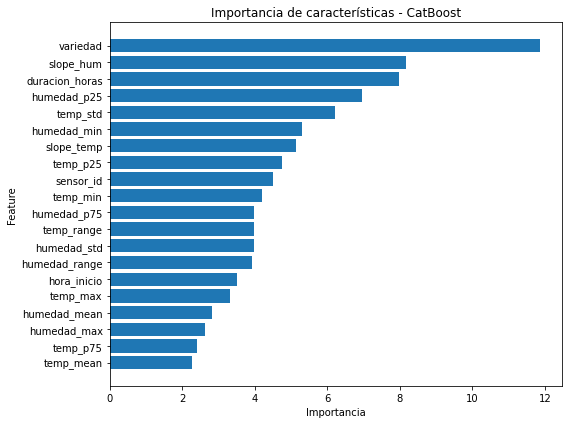

,Feature,Importance
0,variedad,11.863177
1,slope_hum,8.154006
2,duracion_horas,7.969035
3,humedad_p25,6.965688
4,temp_std,6.205240
5,humedad_min,5.299960
6,slope_temp,5.147266
7,temp_p25,4.744016
8,sensor_id,4.488856
9,temp_min,4.211556


In [27]:
# Obtener importancia de características
feature_importances = modelo_cb.get_feature_importance()
features = X_train.columns

# Crear DataFrame ordenado
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar top 20
plt.figure(figsize=(8, 6))
plt.barh(importances_df['Feature'].iloc[:20][::-1], importances_df['Importance'].iloc[:20][::-1])
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('Importancia de características - CatBoost')
plt.tight_layout()
plt.show()

# Mostrar tabla completa ordenada
importances_df.reset_index(drop=True, inplace=True)
importances_df.head(10)

Con esta información, probamos eliminar las features menos importantes y crear nuevas

In [35]:
# Copia para no tocar los originales
X_train_aug = X_train.copy()
X_test_aug = X_test.copy()

# Features derivadas 
# Relación entre temperatura y humedad
X_train_aug["ratio_temp_hum"] = X_train_aug["temp_mean"] / (X_train_aug["humedad_mean"] + 1e-3)
X_test_aug["ratio_temp_hum"]  = X_test_aug["temp_mean"] / (X_test_aug["humedad_mean"] + 1e-3)

# Diferencia entre temperatura y humedad
X_train_aug["temp_hum_gap"] = X_train_aug["temp_mean"] - X_train_aug["humedad_mean"]
X_test_aug["temp_hum_gap"]  = X_test_aug["temp_mean"] - X_test_aug["humedad_mean"]

# Coeficiente de variación (desviación relativa)
X_train_aug["coef_var_temp"] = X_train_aug["temp_std"] / (X_train_aug["temp_mean"] + 1e-3)
X_test_aug["coef_var_temp"]  = X_test_aug["temp_std"] / (X_test_aug["temp_mean"] + 1e-3)

X_train_aug["coef_var_hum"] = X_train_aug["humedad_std"] / (X_train_aug["humedad_mean"] + 1e-3)
X_test_aug["coef_var_hum"]  = X_test_aug["humedad_std"] / (X_test_aug["humedad_mean"] + 1e-3)

# Relación entre duracion y pendiente
X_train_aug["rate_temp"] = X_train_aug["slope_temp"] / (X_train_aug["duracion_horas"] + 1e-3)
X_test_aug["rate_temp"]  = X_test_aug["slope_temp"] / (X_test_aug["duracion_horas"] + 1e-3)

X_train_aug["rate_hum"] = X_train_aug["slope_hum"] / (X_train_aug["duracion_horas"] + 1e-3)
X_test_aug["rate_hum"]  = X_test_aug["slope_hum"] / (X_test_aug["duracion_horas"] + 1e-3)

# Interacción no lineal
X_train_aug["temp_std_x_hum_std"] = X_train_aug["temp_std"] * X_train_aug["humedad_std"]
X_test_aug["temp_std_x_hum_std"]  = X_test_aug["temp_std"] * X_test_aug["humedad_std"]

print(f"Nuevas columnas creadas: {set(X_train_aug.columns) - set(X_train.columns)}")

# Variables menos importantes según el gráfico
cols_drop = ['temp_mean', 'temp_p75', 'humedad_max', 'humedad_mean', 'temp_max']

# Eliminarlas
X_train_aug = X_train_aug.drop(columns=cols_drop, errors='ignore')
X_test_aug = X_test_aug.drop(columns=cols_drop, errors='ignore')

Nuevas columnas creadas: {'ratio_temp_hum', 'rate_temp', 'rate_hum', 'coef_var_hum', 'coef_var_temp', 'temp_hum_gap', 'temp_std_x_hum_std'}


# Catboost 3

Probamos otro catboost con estos datos nuevos pero no mejora el anterior catboost

✅ Resultados modelo_cb2 (clase defectuosa = 1, umbral = 0.2)

Precision: 0.844
Recall:    0.752
F1-score:  0.796


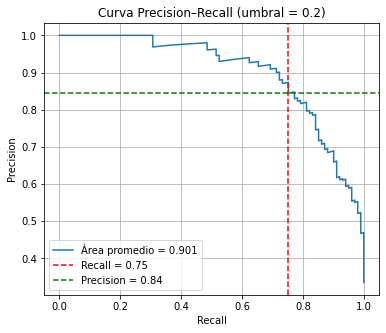

In [37]:
# Columnas categóricas
cat_cols = ["variedad", "sensor_id", "momento_dia"]

#  Modelo CatBoost 2 
modelo_cb2 = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=10,                      
    l2_leaf_reg=3,
    eval_metric="F1",
    class_weights=[1, 3],       
    random_seed=42,
    verbose=0
)

# Entrenamiento
modelo_cb2.fit(X_train_aug, y_train, cat_features=cat_cols)

# Probabilidades
y_prob = modelo_cb2.predict_proba(X_test_aug)[:, 1]

# Umbral para predecir defectuosas 
umbral = 0.2
y_pred = (y_prob >= umbral).astype(int)

# Métricas clase defectuosa 
reporte = classification_report(y_test, y_pred, output_dict=True)
precision_1 = reporte['1']['precision']
recall_1 = reporte['1']['recall']
f1_1 = reporte['1']['f1-score']

print(f"✅ Resultados modelo_cb2 (clase defectuosa = 1, umbral = {umbral})\n")
print(f"Precision: {precision_1:.3f}")
print(f"Recall:    {recall_1:.3f}")
print(f"F1-score:  {f1_1:.3f}")

# Curva Precision–Recall 
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"Área promedio = {ap:.3f}")
plt.axvline(x=recall_1, color="r", linestyle="--", label=f"Recall = {recall_1:.2f}")
plt.axhline(y=precision_1, color="g", linestyle="--", label=f"Precision = {precision_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision–Recall (umbral = {umbral})")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
#A pesar de los cambios, el mejor modelo sigue siendo el catboost inicial, entrenado con el procesamiento de datos incial. 

# XG BOOSTs

Preprocesamiento, pasando las variables categóricas a dummies mediante one hot encoding para que se pueda correr el modelo.
Lo aplicamos sobre el primer conjunto de datos. 

In [41]:
# Copias de los conjuntos originales 
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

# Columnas categóricas a convertir 
cat_cols = ["variedad", "sensor_id", "momento_dia"]

# Crear variables dummies 
X_train_xgb = pd.get_dummies(X_train_xgb, columns=cat_cols, drop_first=True)
X_test_xgb = pd.get_dummies(X_test_xgb, columns=cat_cols, drop_first=True)

# Alinear columnas entre train y test (asegura mismas features) 
X_train_xgb, X_test_xgb = X_train_xgb.align(X_test_xgb, join="left", axis=1, fill_value=0)

print(f"✅ Nuevos datasets para XGBoost creados:")
print(f"X_train_xgb shape: {X_train_xgb.shape}")
print(f"X_test_xgb shape:  {X_test_xgb.shape}")

✅ Nuevos datasets para XGBoost creados:
X_train_xgb shape: (1201, 35)
X_test_xgb shape:  (301, 35)


✅ Resultados XGBoost (con dummies, umbral = 0.25)

Precision: 0.839
Recall:    0.772
F1-score:  0.804


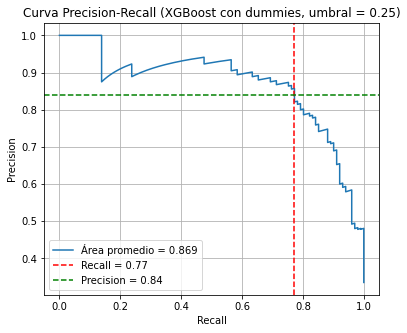

In [50]:
# Modelo
modelo_xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.1,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1.5,  
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)

# Entrenamiento
modelo_xgb.fit(X_train_xgb, y_train)

# Predicciones
y_prob = modelo_xgb.predict_proba(X_test_xgb)[:, 1]
umbral = 0.25
y_pred = (y_prob >= umbral).astype(int)

# Métricas
reporte = classification_report(y_test, y_pred, output_dict=True)
precision_1 = reporte['1']['precision']
recall_1 = reporte['1']['recall']
f1_1 = reporte['1']['f1-score']

print(f"✅ Resultados XGBoost (con dummies, umbral = {umbral})\n")
print(f"Precision: {precision_1:.3f}")
print(f"Recall:    {recall_1:.3f}")
print(f"F1-score:  {f1_1:.3f}")

# Curva Precision-Recall 
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"Área promedio = {ap:.3f}")
plt.axvline(x=recall_1, color="r", linestyle="--", label=f"Recall = {recall_1:.2f}")
plt.axhline(y=precision_1, color="g", linestyle="--", label=f"Precision = {precision_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (XGBoost con dummies, umbral = {umbral})")
plt.legend()
plt.grid(True)
plt.show()

# XGBoost 2

Como dio peor, probamos hacer el mismo preprocesamiento de datos pasando las categóricas a dummies, pero sobre el conjunto X 
de entrenamiento y test enriquecido, con las variables que relacionan humedad y temperatura. 

In [51]:
#  Copias de los conjuntos enriquecidos 
X_train_xgb2 = X_train_aug.copy()
X_test_xgb2 = X_test_aug.copy()

# Columnas categóricas a convertir
cat_cols = ["variedad", "sensor_id", "momento_dia"]

#  Crear variables dummies 
X_train_xgb2 = pd.get_dummies(X_train_xgb2, columns=cat_cols, drop_first=True)
X_test_xgb2 = pd.get_dummies(X_test_xgb2, columns=cat_cols, drop_first=True)

# Alinear columnas entre train y test 
X_train_xgb2, X_test_xgb2 = X_train_xgb2.align(X_test_xgb2, join="left", axis=1, fill_value=0)

print(f"✅ Nuevos datasets para XGBoost creados desde los enriquecidos:")
print(f"X_train_xgb2 shape: {X_train_xgb2.shape}")
print(f"X_test_xgb2 shape:  {X_test_xgb2.shape}")

✅ Nuevos datasets para XGBoost creados desde los enriquecidos:
X_train_xgb2 shape: (1201, 37)
X_test_xgb2 shape:  (301, 37)


✅ Resultados XGBoost (enriquecido, umbral = 0.25)

Precision: 0.830
Recall:    0.772
F1-score:  0.800


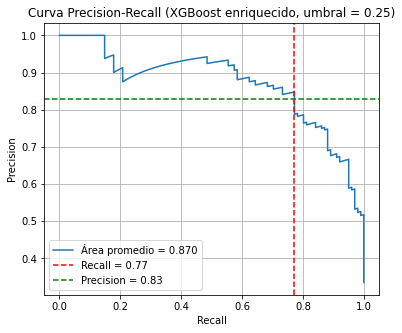

In [53]:
# Modelo
modelo_xgb2 = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3,  
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)

# Entrenamiento
modelo_xgb2.fit(X_train_xgb2, y_train)

# Predicciones
y_prob = modelo_xgb2.predict_proba(X_test_xgb2)[:, 1]
umbral = 0.25
y_pred = (y_prob >= umbral).astype(int)

# Métricas
reporte = classification_report(y_test, y_pred, output_dict=True)
precision_1 = reporte['1']['precision']
recall_1 = reporte['1']['recall']
f1_1 = reporte['1']['f1-score']

print(f"✅ Resultados XGBoost (enriquecido, umbral = {umbral})\n")
print(f"Precision: {precision_1:.3f}")
print(f"Recall:    {recall_1:.3f}")
print(f"F1-score:  {f1_1:.3f}")

# --- Curva Precision-Recall ---
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"Área promedio = {ap:.3f}")
plt.axvline(x=recall_1, color="r", linestyle="--", label=f"Recall = {recall_1:.2f}")
plt.axhline(y=precision_1, color="g", linestyle="--", label=f"Precision = {precision_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (XGBoost enriquecido, umbral = {umbral})")
plt.legend()
plt.grid(True)
plt.show()

# Random Forest 1

✅ Resultados Random Forest (umbral = 0.3)

Precision: 0.764
Recall:    0.832
F1-score:  0.796


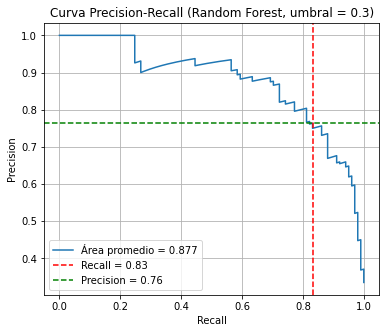

In [74]:
# Variante 1: más peso a defectuosas manualmente
modelo_rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=15,
    min_samples_split=3,
    min_samples_leaf=2,
    class_weight={0:1, 1:4},  
    random_state=42,
    n_jobs=-1
)

# Entrenamiento 
modelo_rf.fit(X_train_xgb, y_train)

# Predicciones 
y_prob = modelo_rf.predict_proba(X_test_xgb)[:, 1]
umbral = 0.3                
y_pred = (y_prob >= umbral).astype(int)

# Métricas (clase defectuosa = 1)
reporte = classification_report(y_test, y_pred, output_dict=True)
precision_1 = reporte['1']['precision']
recall_1 = reporte['1']['recall']
f1_1 = reporte['1']['f1-score']

print(f"✅ Resultados Random Forest (umbral = {umbral})\n")
print(f"Precision: {precision_1:.3f}")
print(f"Recall:    {recall_1:.3f}")
print(f"F1-score:  {f1_1:.3f}")

# Curva Precision-Recall 
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"Área promedio = {ap:.3f}")
plt.axvline(x=recall_1, color="r", linestyle="--", label=f"Recall = {recall_1:.2f}")
plt.axhline(y=precision_1, color="g", linestyle="--", label=f"Precision = {precision_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (Random Forest, umbral = {umbral})")
plt.legend()
plt.grid(True)
plt.show()

# Random Forest 2

✅ Resultados Random Forest (umbral = 0.3)

Precision: 0.735
Recall:    0.822
F1-score:  0.776


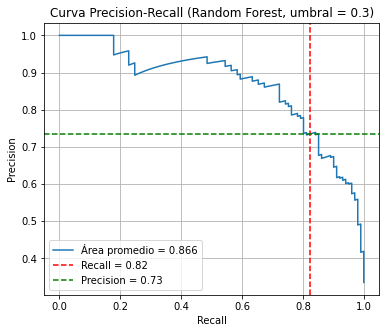

In [77]:
# Modelo Random Forest 
modelo_rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,             
    min_samples_split=5,
    min_samples_leaf=3,
    class_weight='balanced',   
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
modelo_rf.fit(X_train_xgb2, y_train)

# Predicciones
y_prob = modelo_rf.predict_proba(X_test_xgb2)[:, 1]
umbral = 0.3
y_pred = (y_prob >= umbral).astype(int)

# Métricas clase defectuosa 
reporte = classification_report(y_test, y_pred, output_dict=True)
precision_1 = reporte['1']['precision']
recall_1 = reporte['1']['recall']
f1_1 = reporte['1']['f1-score']

print(f"✅ Resultados Random Forest (umbral = {umbral})\n")
print(f"Precision: {precision_1:.3f}")
print(f"Recall:    {recall_1:.3f}")
print(f"F1-score:  {f1_1:.3f}")

# Curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"Área promedio = {ap:.3f}")
plt.axvline(x=recall_1, color="r", linestyle="--", label=f"Recall = {recall_1:.2f}")
plt.axhline(y=precision_1, color="g", linestyle="--", label=f"Precision = {precision_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (Random Forest, umbral = {umbral})")
plt.legend()
plt.grid(True)
plt.show()

Con modelos que agrupan por tachada, se consiguieron unas métricas de
Precision: 0.835
Recall:    0.851
F1-score:  0.843

Se buscará aumentarlas mediante modelos secuenciales, que sí capturan el paso del tiempo a diferencia de estos últimos. 

# Modelos secuenciales

## LSTM

In [79]:
!pip install tensorflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
mysql-connector-python 8.0.32 requires protobuf<=3.20.3,>=3.11.0, but you have protobuf 6.33.0 which is incompatible.



  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.11.0
    Uninstalling typing-extensions-4.11.0:
      Successfully uninstalled typing-extensions-4.11.0
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.10.0
    Uninstalling Pygments-2.10.0:
      Successfully uninstalled Pygments-2.10.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.2.1
    Uninstalling h5py-3.2.1:
      Successfully uninstalled h5py-3.2.1


In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [117]:

df2 = df.copy()

# Contar filas con variedad vacía
faltantes_variedad = df2['Variedad'].isna().sum() + (df2['Variedad'].astype(str).str.strip() == '').sum()

print(f"🔍 Filas con Variedad vacía o nula: {faltantes_variedad}")

# Eliminar esas filas
df2 = df2[~df2['Variedad'].isna()]
df2 = df2[df2['Variedad'].astype(str).str.strip() != '']

cols_drop = ["planta", "año", "VOL_HUM", "VOL_TEM"]
df2 = df2.drop(columns=cols_drop, errors="ignore")

print(f"✅ DataFrame limpio — nuevo shape: {df2.shape}")

🔍 Filas con Variedad vacía o nula: 828
✅ DataFrame limpio — nuevo shape: (196874, 10)


In [118]:
# One-hot encoding
df2 = pd.get_dummies(df2, columns=["Variedad"], drop_first=False)

print("✅ One-Hot Encoding aplicado a 'variedad'")

✅ One-Hot Encoding aplicado a 'variedad'


In [119]:
df2.dtypes

tirada_fecha        datetime64[ns]
sensor_id                    int64
timestamp           datetime64[ns]
VOLT_HUM                   float64
VOLT_TEM                   float64
ID_tachada                   int64
DESCARTAR                    int64
HUMEDAD                    float64
TEMPERATURA                float64
Variedad_404                  bool
Variedad_9193                 bool
Variedad_CL1202               bool
Variedad_GURÍ                 bool
Variedad_INOV                 bool
Variedad_L5903                bool
Variedad_MERÍN                bool
Variedad_OLIMAR               bool
Variedad_SAMBA                bool
Variedad_TACUARÍ              bool
dtype: object

In [120]:
# Columnas numéricas a escalar
cols_num = ["HUMEDAD", "TEMPERATURA"]


scaler = MinMaxScaler()
df2[cols_num] = scaler.fit_transform(df2[cols_num])


df2["sensor_id"] = df2["sensor_id"].astype(str)
df2 = pd.get_dummies(df2, columns=["sensor_id"], prefix="sensor")

print("✅ HUMEDAD y TEMPERATURA escaladas, sensor_id convertido a dummies")
print(df2.filter(like="sensor_").head())

✅ HUMEDAD y TEMPERATURA escaladas, sensor_id convertido a dummies
   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6
0     False      True     False     False     False     False
1     False      True     False     False     False     False
2     False      True     False     False     False     False
3     False      True     False     False     False     False
4     False      True     False     False     False     False


In [121]:
# Aseguramos orden temporal dentro de cada tachada
df2 = df2.sort_values(["ID_tachada", "timestamp"])


X_cols = [c for c in df2.columns if c not in ["DESCARTAR", "ID_tachada", "timestamp", "tirada_fecha"]]
y_col = "DESCARTAR"

# Agrupamos por tachada
X_seq = [group[X_cols].values for _, group in df2.groupby("ID_tachada")]
y_seq = [group[y_col].iloc[0] for _, group in df2.groupby("ID_tachada")]

X_seq_padded = pad_sequences(X_seq, padding='post', dtype='float32')
y_seq = np.array(y_seq)

print("✅ Secuencias agrupadas por tachada y normalizadas")
print(f"Dimensiones finales de X_seq_padded: {X_seq_padded.shape}")

✅ Secuencias agrupadas por tachada y normalizadas
Dimensiones finales de X_seq_padded: (1492, 1518, 20)


In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq_padded, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

print(f"✅ Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

✅ Train: 1193 | Test: 299


In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

n_features = X_train.shape[2]

modelo_lstm = Sequential([
    LSTM(64, input_shape=(None, n_features), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

modelo_lstm.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['Precision', 'Recall']
)

modelo_lstm.summary()

C:\Users\Usuario\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          21,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,873 (93.25 KB)

 Trainable params: 23,873 (93.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.5872 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.5794
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 363ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.5928 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.5792
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 361ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.5695 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.5789
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.5737 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.5788
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 394ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.5668 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.5786
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 396ms/step - Precision: 0.0000e+0

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


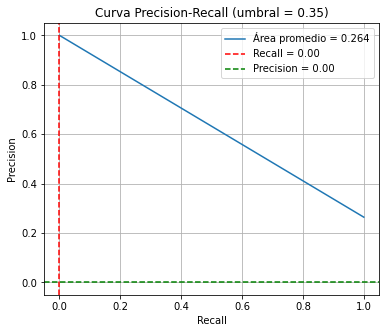

In [105]:
hist = modelo_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    verbose=1
)

# Predicciones
y_prob = modelo_lstm.predict(X_test).ravel()
umbral = 0.35
y_pred = (y_prob >= umbral).astype(int)

# Métricas
reporte = classification_report(y_test, y_pred, output_dict=True)
precision_1 = reporte['1']['precision']
recall_1 = reporte['1']['recall']
f1_1 = reporte['1']['f1-score']

print(f"\n✅ Resultados LSTM (clase defectuosa = 1, umbral = {umbral})\n")
print(f"Precision: {precision_1:.3f}")
print(f"Recall:    {recall_1:.3f}")
print(f"F1-score:  {f1_1:.3f}")

# Curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"Área promedio = {ap:.3f}")
plt.axvline(x=recall_1, color="r", linestyle="--", label=f"Recall = {recall_1:.2f}")
plt.axhline(y=precision_1, color="g", linestyle="--", label=f"Precision = {precision_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (umbral = {umbral})")
plt.legend()
plt.grid(True)
plt.show()


Dado que LSTM no parece ajustarse a nuestros datos y dar buenas métricas, probaremos con GRU, una versión más simplificada de 
LSTM, que se ajusta mejor cuando los datos no tienen secuencias tan largas. Aprende de patrones más cortos y es menos propensa al sobreajuste

## GRU

In [124]:

df3 = df.copy()


faltantes_variedad = df3['Variedad'].isna().sum() + (df3['Variedad'].astype(str).str.strip() == '').sum()
print(f"🔍 Filas con Variedad vacía o nula: {faltantes_variedad}")

# Eliminar filas sin variedad 
df3 = df3[~df3['Variedad'].isna()]
df3 = df3[df3['Variedad'].astype(str).str.strip() != '']

print(f"✅ DataFrame sin valores vacíos en Variedad — shape: {df3.shape}")

🔍 Filas con Variedad vacía o nula: 828
✅ DataFrame sin valores vacíos en Variedad — shape: (196874, 12)


In [125]:
# One-hot encoding de la columna Variedad
df3 = pd.get_dummies(df3, columns=["Variedad"], drop_first=False)
print("✅ One-Hot Encoding aplicado a 'Variedad'")

✅ One-Hot Encoding aplicado a 'Variedad'


In [126]:
# Columnas numéricas a escalar
cols_num = ["HUMEDAD", "TEMPERATURA"]

scaler = MinMaxScaler()
df3[cols_num] = scaler.fit_transform(df3[cols_num])

print("✅ HUMEDAD y TEMPERATURA escaladas entre 0 y 1")


✅ HUMEDAD y TEMPERATURA escaladas entre 0 y 1


In [127]:
# Convertir sensor a string y aplicar One-Hot Encoding
df3["sensor_id"] = df3["sensor_id"].astype(str)
df3 = pd.get_dummies(df3, columns=["sensor_id"], prefix="sensor")

print("✅ sensor_id convertido a dummies correctamente")

✅ sensor_id convertido a dummies correctamente


In [128]:
# Eliminar columnas innecesarias
cols_drop = ["planta", "año", "VOL_HUM", "VOL_TEM", "tirada_fecha", "timestamp_inicial", "timestamp_final"]
df3 = df3.drop(columns=cols_drop, errors="ignore")

print(f"✅ Columnas irrelevantes eliminadas — nuevo shape: {df3.shape}")
print("📋 Columnas finales:")
print(df3.columns.tolist())

✅ Columnas irrelevantes eliminadas — nuevo shape: (196874, 23)
📋 Columnas finales:
['timestamp', 'VOLT_HUM', 'VOLT_TEM', 'ID_tachada', 'DESCARTAR', 'HUMEDAD', 'TEMPERATURA', 'Variedad_404', 'Variedad_9193', 'Variedad_CL1202', 'Variedad_GURÍ', 'Variedad_INOV', 'Variedad_L5903', 'Variedad_MERÍN', 'Variedad_OLIMAR', 'Variedad_SAMBA', 'Variedad_TACUARÍ', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6']


In [129]:

print("🔍 Tipos de datos en df3:")
print(df3.dtypes.value_counts())
print("\nColumnas datetime:", df3.select_dtypes(include=['datetime', 'datetimetz']).columns.tolist())

🔍 Tipos de datos en df3:
bool              16
float64            4
int64              2
datetime64[ns]     1
Name: count, dtype: int64

Columnas datetime: ['timestamp']


In [130]:
# Ordenar por ID_tachada y timestamp
df3 = df3.sort_values(by=["ID_tachada", "timestamp"])


X_cols = [c for c in df3.columns if c not in ["ID_tachada", "DESCARTAR", "timestamp"]]
y_col = "DESCARTAR"

# Agrupar por tachada
X_seq = [group[X_cols].values for _, group in df3.groupby("ID_tachada")]
y_seq = [group[y_col].iloc[0] for _, group in df3.groupby("ID_tachada")]

# Padding de secuencias
X_seq_padded = pad_sequences(X_seq, padding='post', dtype='float32')
y_seq = np.array(y_seq)

print("✅ Padding completado — listo para train/test split y GRU.")
print(f"📊 Shape de X_seq_padded: {X_seq_padded.shape}")
print(f"📊 Shape de y_seq: {y_seq.shape}")

✅ Padding completado — listo para train/test split y GRU.
📊 Shape de X_seq_padded: (1492, 1518, 20)
📊 Shape de y_seq: (1492,)


In [131]:
# Dividimos las secuencias en train/test
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq_padded, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

print(f"✅ Train shape: {X_train_seq.shape}, Test shape: {X_test_seq.shape}")

✅ Train shape: (1193, 1518, 20), Test shape: (299, 1518, 20)


In [132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Crear modelo secuencial GRU
modelo_gru = Sequential([
    GRU(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compilación
modelo_gru.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

modelo_gru.summary()

C:\Users\Usuario\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 64)                  │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,625 (72.75 KB)

 Trainable params: 18,625 (72.75 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
from tensorflow.keras.callbacks import EarlyStopping

# Entrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist_gru = modelo_gru.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=80,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("✅ Entrenamiento GRU finalizado")

Epoch 1/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 439ms/step - accuracy: 0.7534 - loss: 0.6911 - val_accuracy: 0.7358 - val_loss: 0.6851
Epoch 2/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 472ms/step - accuracy: 0.7475 - loss: 0.6827 - val_accuracy: 0.7358 - val_loss: 0.6773
Epoch 3/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 439ms/step - accuracy: 0.7413 - loss: 0.6752 - val_accuracy: 0.7358 - val_loss: 0.6702
Epoch 4/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 446ms/step - accuracy: 0.7308 - loss: 0.6690 - val_accuracy: 0.7358 - val_loss: 0.6632
Epoch 5/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 447ms/step - accuracy: 0.7219 - loss: 0.6635 - val_accuracy: 0.7358 - val_loss: 0.6567
Epoch 6/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 448ms/step - accuracy: 0.7212 - loss: 0.6578 - val_accuracy: 0.7358 - val_loss: 0.6508
Epoch 7/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - accuracy: 0.7524 - loss: 0.6460 - val_accuracy: 0.7358 - val_loss: 0.6450
Epoch 8/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 492ms/step - accuracy: 0.7310 - loss: 0.6448 - val_accu

In [150]:
y_prob = modelo_gru.predict(X_test_seq).ravel()

umbral = 0.2670
y_pred = (y_prob >= umbral).astype(int)

precision = precision_score(y_test_seq, y_pred)
recall = recall_score(y_test_seq, y_pred)
f1 = f1_score(y_test_seq, y_pred)

print(f"✅ Resultados GRU (clase defectuosa = 1, umbral = {umbral})\n")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
✅ Resultados GRU (clase defectuosa = 1, umbral = 0.267)

Precision: 0.264
Recall:    1.000
F1-score:  0.418


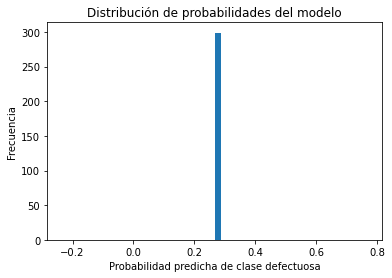

In [151]:
plt.hist(y_prob, bins=50)
plt.title("Distribución de probabilidades del modelo")
plt.xlabel("Probabilidad predicha de clase defectuosa")
plt.ylabel("Frecuencia")
plt.show()

In [152]:
df3["DESCARTAR"].value_counts(normalize=True)

DESCARTAR
0    0.766175
1    0.233825
Name: proportion, dtype: float64

In [153]:
df3[["HUMEDAD","TEMPERATURA"]].describe()

,HUMEDAD,TEMPERATURA
count,183004.000000,183004.000000
mean,0.694859,0.373019
std,0.029751,0.051522
min,0.000000,0.000000
25%,0.673491,0.349593
50%,0.690595,0.377039
75%,0.713495,0.403221
max,1.000000,1.000000


In [154]:
df3.groupby("ID_tachada")[["HUMEDAD","TEMPERATURA"]].std().describe()

,HUMEDAD,TEMPERATURA
count,1450.000000,1450.000000
mean,0.018878,0.029312
std,0.009607,0.015780
min,0.000000,0.000000
25%,0.012733,0.019029
50%,0.018570,0.026470
75%,0.024268,0.036101
max,0.183640,0.147632


Los modelos secuenciales (LSTM y GRU) no funcionaron bien porque las variables temporales de entrada, como HUMEDAD y TEMPERATURA, casi no varían dentro de cada tachada, lo que impide que el modelo aprenda patrones en el tiempo. Además, al estar las clases desbalanceadas, las redes tendieron a predecir siempre la clase mayoritaria. En resumen, el modelo terminó aprendiendo el promedio general y no logró diferenciar las tachadas defectuosas. Se buscará corregir esto con el uso de modelos híbridos.

# Modelos Híbridos

In [155]:
df.dtypes

planta                  object
año                      int64
tirada_fecha    datetime64[ns]
sensor_id                int64
timestamp       datetime64[ns]
VOLT_HUM               float64
VOLT_TEM               float64
Variedad                object
ID_tachada               int64
DESCARTAR                int64
HUMEDAD                float64
TEMPERATURA            float64
dtype: object

In [160]:
from sklearn.preprocessing import LabelEncoder

df4 = df.copy()
print(f"✅ Copia creada — df4 shape: {df4.shape}")

# Limpieza
faltantes_variedad = df4['Variedad'].isna().sum() + (df4['Variedad'].astype(str).str.strip() == '').sum()
print(f"🔍 Filas con Variedad vacía o nula: {faltantes_variedad}")

df4 = df4[df4['Variedad'].notna()]
df4 = df4[df4['Variedad'].astype(str).str.strip() != '']

cols_drop = ["planta", "año", "VOL_HUM", "VOL_TEM"]
df4 = df4.drop(columns=cols_drop, errors="ignore")

✅ Copia creada — df4 shape: (197702, 12)
🔍 Filas con Variedad vacía o nula: 828


In [161]:
def calcular_features_tachada(grupo):
    grupo = grupo.sort_values("timestamp")
    if grupo.shape[0] < 2:
        grupo["slope_hum"] = 0
        grupo["slope_temp"] = 0
        grupo["duracion_horas"] = 0
    else:
        delta_t = (grupo["timestamp"].iloc[-1] - grupo["timestamp"].iloc[0]).total_seconds() / 3600
        if delta_t == 0:
            delta_t = 1e-6
        grupo["slope_hum"] = (grupo["HUMEDAD"].iloc[-1] - grupo["HUMEDAD"].iloc[0]) / delta_t
        grupo["slope_temp"] = (grupo["TEMPERATURA"].iloc[-1] - grupo["TEMPERATURA"].iloc[0]) / delta_t
        grupo["duracion_horas"] = delta_t
    return grupo

df4 = df4.groupby("ID_tachada", group_keys=False).apply(calcular_features_tachada)
print("✅ Slopes y duración calculados por tachada.")

✅ Slopes y duración calculados por tachada.


C:\Users\Usuario\AppData\Local\Temp/ipykernel_5092/942580675.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df4 = df4.groupby("ID_tachada", group_keys=False).apply(calcular_features_tachada)


In [162]:

df4[['HUMEDAD_norm', 'TEMPERATURA_norm']] = (
    df4.groupby('ID_tachada')[['HUMEDAD', 'TEMPERATURA']]
        .transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6))
)
print("✅ Normalización por tachada completada.")


✅ Normalización por tachada completada.


In [163]:
# Convertimos las categorías a números enteros
for col in ["Variedad", "sensor_id"]:
    le = LabelEncoder()
    df4[col] = le.fit_transform(df4[col].astype(str))
    print(f"🔢 Codificada {col}: {len(le.classes_)} categorías.")

🔢 Codificada Variedad: 10 categorías.
🔢 Codificada sensor_id: 6 categorías.


In [168]:
#Crear dataset agregado por tachada
aggs = df4.groupby("ID_tachada").agg({
    "HUMEDAD": ["mean", "std", "min", "max"],
    "TEMPERATURA": ["mean", "std", "min", "max"],
    "slope_hum": "mean",
    "slope_temp": "mean",
    "duracion_horas": "mean",
    "Variedad": "first",
    "sensor_id": "first",
    "DESCARTAR": "first"  
}).reset_index()

# Renombrar columnas
aggs.columns = ["ID_tachada"] + ["_".join(col).strip() for col in aggs.columns[1:]]

print("✅ Dataset agregado por tachada con DESCARTAR incluido.")

✅ Dataset agregado por tachada con DESCARTAR incluido.


In [169]:
target_col = "DESCARTAR"  

X_seq, y_seq = [], []

for _, grupo in df4.groupby("ID_tachada"):
    grupo = grupo.sort_values("timestamp")
    X_seq.append(grupo[["HUMEDAD_norm", "TEMPERATURA_norm"]].values)
    y_seq.append(grupo[target_col].iloc[0])

X_seq_padded = pad_sequences(X_seq, padding='post', dtype='float32')
y_seq = np.array(y_seq)

print(f"✅ Secuencias listas: {X_seq_padded.shape}, Targets: {y_seq.shape}")

✅ Secuencias listas: (1492, 1518, 2), Targets: (1492,)


In [176]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [172]:
# Datos para las dos entradas 
X_tab = aggs.drop(columns=["ID_tachada", "DESCARTAR_first"]).values  
X_seq_final = X_seq_padded                                           
y_final = aggs["DESCARTAR_first"].values                             
                                            
# División en train/test 
X_seq_train, X_seq_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_seq_final, X_tab, y_final, test_size=0.2, random_state=42, stratify=y_final
)

#  Entradas 
seq_input = Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2]), name="secuencial")
tab_input = Input(shape=(X_tab_train.shape[1],), name="tabular")

#secuencial
x1 = GRU(64, return_sequences=False)(seq_input)
x1 = Dropout(0.3)(x1)

# tabular 
x2 = Dense(64, activation="relu")(tab_input)
x2 = Dropout(0.3)(x2)
x2 = Dense(32, activation="relu")(x2)

#  Combinación
combined = Concatenate()([x1, x2])
z = Dense(32, activation="relu")(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation="sigmoid")(z)

modelo_hibrido = Model(inputs=[seq_input, tab_input], outputs=output)

# Compilación
modelo_hibrido.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [202]:
#Calcular pesos de clase para manejar el desbalance
clases = np.unique(y_final)
pesos = compute_class_weight(class_weight='balanced', classes=clases, y=y_final)
class_weights = dict(zip(clases, pesos))

print(" Pesos de clase calculados:", class_weights)

input_seq = Input(shape=(X_seq_final.shape[1], X_seq_final.shape[2]), name="entrada_secuencial")
x_seq = GRU(64, return_sequences=False, dropout=0.3)(input_seq)
x_seq = Dense(32, activation='relu')(x_seq)


input_tab = Input(shape=(X_tab.shape[1],), name="entrada_tabular")
x_tab = Dense(64, activation='relu')(input_tab)
x_tab = Dropout(0.3)(x_tab)
x_tab = Dense(32, activation='relu')(x_tab)

# 4. Fusión
x = Concatenate()([x_seq, x_tab])
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

# 5. Modelo final
modelo_hibrido = Model(inputs=[input_seq, input_tab], outputs=output)

# 6. Compilación
modelo_hibrido.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['Precision', 'Recall', 'AUC'])

modelo_hibrido.summary()

⚖️ Pesos de clase calculados: {0: 0.6800364630811303, 1: 1.888607594936709}


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ entrada_tabular (InputLayer)  │ (None, 13)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ entrada_secuencial            │ (None, 1518, 2)           │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_22 (Dense)              │ (None, 64)                │             896 │ entrada_tabular[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_3 (GRU)                   │ (None, 64)                │          13,056 │ entrada_secuencial[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_17 (Dropout)          │ (None, 64)                │               0 │ dense_22[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_21 (Dense)              │ (None, 32)                │           2,080 │ gru_3[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_23 (Dense)              │ (None, 32)                │           2,080 │ dropout_17[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_4 (Concatenate)   │ (None, 64)                │               0 │ dense_21[0][0],            │
│                               │                           │                 │ dense_23[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_24 (Dense)              │ (None, 32)                │           2,080 │ concatenate_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_18 (Dropout)          │ (None, 32)                │               0 │ dense_24[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_25 (Dense)              │ (None, 1)                 │              33 │ dropout_18[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 20,225 (79.00 KB)

 Trainable params: 20,225 (79.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 879ms/step - AUC: 0.4940 - Precision: 0.1790 - Recall: 0.1471 - loss: 0.8844 - val_AUC: 0.5000 - val_Precision: 0.1940 - val_Recall: 1.0000 - val_loss: 0.6957
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 867ms/step - AUC: 0.4826 - Precision: 0.2653 - Recall: 1.0000 - loss: 0.6936 - val_AUC: 0.5000 - val_Precision: 0.1940 - val_Recall: 1.0000 - val_loss: 0.6979
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 899ms/step - AUC: 0.5000 - Precision: 0.2956 - Recall: 1.0000 - loss: 0.7184 - val_AUC: 0.5000 - val_Precision: 0.1940 - val_Recall: 1.0000 - val_loss: 0.7008
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 860ms/step - AUC: 0.5061 - Precision: 0.2877 - Recall: 1.0000 - loss: 0.7117 - val_AUC: 0.5000 - val_Precision: 0.1940 - val_Recall: 1.0000 - val_loss: 0.7032
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 854ms/step - AUC: 0.5040 - Precision: 0.2798 - Recall: 1.0000 - loss: 0.7053 - val_AUC: 0.5000 - val_Precision: 0.1940 - val_Recall: 1.0000 - val_loss: 0.

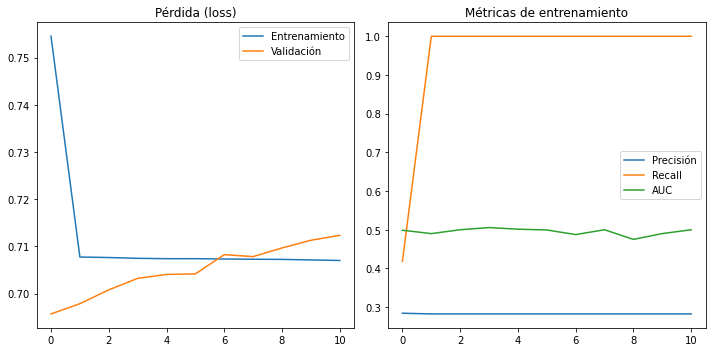

In [203]:
# Early stopping 
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento 
hist = modelo_hibrido.fit(
    [X_seq_final, X_tab],
    y_final,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Graficar métricas
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'], label='Entrenamiento')
plt.plot(hist.history['val_loss'], label='Validación')
plt.title('Pérdida (loss)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['Precision'], label='Precisión')
plt.plot(hist.history['Recall'], label='Recall')
plt.plot(hist.history['AUC'], label='AUC')
plt.title('Métricas de entrenamiento')
plt.legend()
plt.tight_layout()
plt.show()

In [204]:
from sklearn.metrics import classification_report

# Predicciones
y_prob = modelo_hibrido.predict([X_seq_final, X_tab])
y_pred = (y_prob >= 0.25).astype(int)

print("📊 Reporte de métricas (umbral = 0.25):")
print(classification_report(y_final, y_pred, digits=3))

47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step
📊 Reporte de métricas (umbral = 0.25):
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      1097
           1      0.265     1.000     0.419       395

    accuracy                          0.265      1492
   macro avg      0.132     0.500     0.209      1492
weighted avg      0.070     0.265     0.111      1492



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Segundo modelo híbrido

In [181]:
scaler = MinMaxScaler()
df4[['HUMEDAD', 'TEMPERATURA']] = scaler.fit_transform(df4[['HUMEDAD', 'TEMPERATURA']])


✅ Normalización global aplicada correctamente a HUMEDAD y TEMPERATURA.


In [182]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [183]:

clases = np.unique(y_train)
pesos = compute_class_weight(class_weight='balanced', classes=clases, y=y_train)
class_weights = dict(zip(clases, pesos))

print(class_weights)

⚖️ Pesos de clase calculados:
{0: 0.6801596351197263, 1: 1.8876582278481013}


In [184]:

input_seq = Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2]), name="input_secuencial")

x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_seq)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dropout(0.3)(x)


input_tab = Input(shape=(X_tab_train.shape[1],), name="input_tabular")
y = Dense(64, activation='relu')(input_tab)
y = Dropout(0.3)(y)


combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)

modelo_cnn_hibrido = Model(inputs=[input_seq, input_tab], outputs=output)
modelo_cnn_hibrido.compile(optimizer=Adam(learning_rate=0.001),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
modelo_cnn_hibrido.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_secuencial (InputLayer) │ (None, 1518, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 1518, 32)          │             224 │ input_secuencial[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 759, 32)           │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 759, 64)           │           6,208 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_1               │ (None, 379, 64)           │               0 │ conv1d_1[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_tabular (InputLayer)    │ (None, 13)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 24256)             │               0 │ max_pooling1d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_15 (Dense)              │ (None, 64)                │             896 │ input_tabular[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 24256)             │               0 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 64)                │               0 │ dense_15[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 24320)             │               0 │ dropout_11[0][0],          │
│                               │                           │                 │ dropout_12[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_16 (Dense)              │ (None, 64)                │       1,556,544 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_13 (Dropout)          │ (None, 64)                │               0 │ dense_16[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_17 (Dense)              │ (None, 1)                 │              65 │ dropout_13[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,563,937 (5.97 MB)

 Trainable params: 1,563,937 (5.97 MB)

 Non-trainable params: 0 (0.00 B)

In [185]:
history = modelo_cnn_hibrido.fit(
    [X_seq_train, X_tab_train], y_train,
    validation_data=([X_seq_test, X_tab_test], y_test),
    epochs=40,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.6974 - loss: nan - val_accuracy: 0.7358 - val_loss: nan
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7307 - loss: nan - val_accuracy: 0.7358 - val_loss: nan
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7423 - loss: nan - val_accuracy: 0.7358 - val_loss: nan
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7365 - loss: nan - val_accuracy: 0.7358 - val_loss: nan
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7336 - loss: nan - val_accuracy: 0.7358 - val_loss: nan
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7381 - loss: nan - val_accuracy: 0.7358 - val_loss: nan
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7375 - loss: nan - val_accuracy: 0.7358 - val_loss: nan
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7337 - loss: nan - val_accuracy: 0.7358 - val_loss: nan
Epoch 9/40
38/38 ━━━━━━━━━━━━━━

In [192]:
print("🔍 Revisión de NaN en los datos:")

print("Secuencial:")
print(np.isnan(X_seq_test).sum())

print("\nTabular:")
print(np.isnan(X_tab_test).sum())

print("\nTarget:")
print(np.isnan(y_test).sum())


🔍 Revisión de NaN en los datos:
Secuencial:
6144

Tabular:
192

Target:
0


In [193]:
X_tab_train = np.nan_to_num(X_tab_train, nan=0)
X_tab_test  = np.nan_to_num(X_tab_test, nan=0)
X_seq_train = np.nan_to_num(X_seq_train, nan=0)
X_seq_test  = np.nan_to_num(X_seq_test, nan=0)

In [195]:
print("Varianza media HUMEDAD:", np.var(X_seq_train[:,:,0]))
print("Varianza media TEMPERATURA:", np.var(X_seq_train[:,:,1]))

Varianza media HUMEDAD: 0.022754805
Varianza media TEMPERATURA: 0.032431144


In [196]:
modelo_cnn_hibrido.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0),  # penaliza más los falsos negativos
    metrics=['accuracy']
)

In [197]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryFocalCrossentropy


input_seq = Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2]), name="input_secuencial")

x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_seq)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dropout(0.4)(x)


input_tab = Input(shape=(X_tab_train.shape[1],), name="input_tabular")
y = Dense(128, activation='relu')(input_tab)
y = Dropout(0.4)(y)


combined = concatenate([x, y])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.4)(z)
output = Dense(1, activation='sigmoid')(z)


modelo_cnn_hibrido = Model(inputs=[input_seq, input_tab], outputs=output)

modelo_cnn_hibrido.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=BinaryFocalCrossentropy(gamma=2.0),
    metrics=['accuracy']
)

modelo_cnn_hibrido.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_secuencial (InputLayer) │ (None, 1518, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 1518, 32)          │             224 │ input_secuencial[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_2               │ (None, 759, 32)           │               0 │ conv1d_2[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 759, 64)           │           6,208 │ max_pooling1d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_3               │ (None, 379, 64)           │               0 │ conv1d_3[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_tabular (InputLayer)    │ (None, 13)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 24256)             │               0 │ max_pooling1d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_18 (Dense)              │ (None, 128)               │           1,792 │ input_tabular[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_14 (Dropout)          │ (None, 24256)             │               0 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_15 (Dropout)          │ (None, 128)               │               0 │ dense_18[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 24384)             │               0 │ dropout_14[0][0],          │
│                               │                           │                 │ dropout_15[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_19 (Dense)              │ (None, 128)               │       3,121,280 │ concatenate_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_16 (Dropout)          │ (None, 128)               │               0 │ dense_19[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 1)                 │             129 │ dropout_16[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,129,633 (11.94 MB)

 Trainable params: 3,129,633 (11.94 MB)

 Non-trainable params: 0 (0.00 B)

In [198]:
history = modelo_cnn_hibrido.fit(
    [X_seq_train, X_tab_train], y_train,
    validation_data=([X_seq_test, X_tab_test], y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.5725 - loss: 0.3106 - val_accuracy: 0.7893 - val_loss: 0.1440
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6821 - loss: 0.6564 - val_accuracy: 0.8161 - val_loss: 0.1319
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7119 - loss: 0.3712 - val_accuracy: 0.8294 - val_loss: 0.1271
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7355 - loss: 0.4950 - val_accuracy: 0.7023 - val_loss: 0.1491
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6896 - loss: 0.3607 - val_accuracy: 0.8294 - val_loss: 0.1267
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7973 - loss: 0.4825 - val_accuracy: 0.7893 - val_loss: 0.1274
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7644 - loss: 0.3802 - val_accuracy: 0.8261 - val_loss: 0.1129
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8045 - loss: 0.1636 - val_accuracy: 0.8294 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
✅ Resultados CNN-1D Híbrido (umbral = 0.4)
Precision: 0.435
Recall:    0.848
F1-score:  0.575


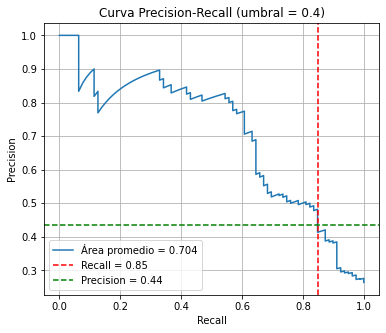

In [205]:
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np


y_prob = modelo_cnn_hibrido.predict([X_seq_test, X_tab_test]).ravel()


umbral = 0.4
y_pred = (y_prob >= umbral).astype(int)


reporte = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
precision_1 = reporte['1']['precision']
recall_1 = reporte['1']['recall']
f1_1 = reporte['1']['f1-score']

print(f"✅ Resultados CNN-1D Híbrido (umbral = {umbral})")
print(f"Precision: {precision_1:.3f}")
print(f"Recall:    {recall_1:.3f}")
print(f"F1-score:  {f1_1:.3f}")


precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"Área promedio = {ap:.3f}")
plt.axvline(x=recall_1, color="r", linestyle="--", label=f"Recall = {recall_1:.2f}")
plt.axhline(y=precision_1, color="g", linestyle="--", label=f"Precision = {precision_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (umbral = {umbral})")
plt.legend()
plt.grid(True)
plt.show()

Si bien logra aprender, las métricas están lejos de ser mejores que el catboost 2

# Mini Rocket

In [214]:

df5 = df.copy()
print(f"✅ Copia creada — df5 shape: {df5.shape}")


faltantes_variedad = df5['Variedad'].isna().sum() + (df5['Variedad'].astype(str).str.strip() == '').sum()
print(f"🔍 Filas con Variedad vacía o nula: {faltantes_variedad}")


df5 = df5[df5['Variedad'].notna()]
df5 = df5[df5['Variedad'].astype(str).str.strip() != '']


cols_drop = ["planta", "año", "VOLT_HUM", "VOLT_TEM"]
df5 = df5.drop(columns=cols_drop, errors="ignore")

print(f"✅ df5 limpio — nuevo shape: {df5.shape}")

✅ Copia creada — df5 shape: (197702, 12)
🔍 Filas con Variedad vacía o nula: 828
✅ df5 limpio — nuevo shape: (196874, 8)


In [215]:
def safe_slope(x):
    """Devuelve la pendiente si hay variabilidad, sino 0."""
    try:
        if len(x) > 1 and np.std(x) > 0:
            return np.polyfit(range(len(x)), x, 1)[0]
        else:
            return 0.0
    except:
        return 0.0

# Calcular pendientes
df5["slope_hum"] = df5.groupby("ID_tachada")["HUMEDAD"].transform(safe_slope)
df5["slope_temp"] = df5.groupby("ID_tachada")["TEMPERATURA"].transform(safe_slope)

# Calcular duración
df5["duracion_horas"] = df5.groupby("ID_tachada")["timestamp"].transform(
    lambda x: (x.max() - x.min()).total_seconds() / 3600 if len(x) > 1 else 0
)


✅ Variables slope y duración calculadas correctamente (sin errores numéricos)


In [216]:
df5[["ID_tachada", "slope_hum", "slope_temp", "duracion_horas"]].head()

,ID_tachada,slope_hum,slope_temp,duracion_horas
0,20042,0.0,0.0,13.248056
1,20042,0.0,0.0,13.248056
2,20042,0.0,0.0,13.248056
3,20042,0.0,0.0,13.248056
4,20042,0.0,0.0,13.248056


In [220]:

cols_seq = ["HUMEDAD", "TEMPERATURA"]


secuencias = []
y = []
ids_tachada = []

for tachada, grupo in df5.groupby("ID_tachada"):
    matriz = grupo[cols_seq].values
    secuencias.append(matriz)
    y.append(grupo["DESCARTAR"].iloc[0])
    ids_tachada.append(tachada)

# Igualar longitudes
max_len = max(len(seq) for seq in secuencias)
X_seq = np.array([
    np.pad(seq, ((0, max_len - len(seq)), (0, 0)), mode='edge') if len(seq) < max_len else seq[:max_len]
    for seq in secuencias
])

y = np.array(y)
print(f"✅ X_seq listo — shape: {X_seq.shape}, y shape: {y.shape}")


X_seq_train, X_seq_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.25, random_state=42, stratify=y)

✅ X_seq listo — shape: (1492, 1518, 2), y shape: (1492,)


In [218]:
df5.columns.tolist()

['tirada_fecha',
 'sensor_id',
 'timestamp',
 'Variedad',
 'ID_tachada',
 'DESCARTAR',
 'HUMEDAD',
 'TEMPERATURA',
 'slope_hum',
 'slope_temp',
 'duracion_horas']

In [221]:

aggs = df5.groupby("ID_tachada").agg({
    "HUMEDAD": ["mean", "std", "min", "max", lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
    "TEMPERATURA": ["mean", "std", "min", "max", lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
    "slope_hum": "first",
    "slope_temp": "first",
    "duracion_horas": "first",
    "Variedad": "first",
    "sensor_id": "first"
}).reset_index()


aggs.columns = [
    "ID_tachada",
    "hum_mean", "hum_std", "hum_min", "hum_max", "hum_p25", "hum_p75",
    "temp_mean", "temp_std", "temp_min", "temp_max", "temp_p25", "temp_p75",
    "slope_hum", "slope_temp", "duracion_horas",
    "Variedad", "sensor_id"
]


aggs = aggs.merge(df5.groupby("ID_tachada")["DESCARTAR"].first().reset_index(), on="ID_tachada")

print(f"✅ Tabla tabular extendida lista con {aggs.shape[1]} columnas y {aggs.shape[0]} filas")

✅ Tabla tabular extendida lista con 19 columnas y 1492 filas


In [223]:
!pip install sktime

In [224]:
from sktime.transformations.panel.rocket import MiniRocket
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [226]:
!pip uninstall -y numba llvmlite
!pip install numba==0.58.1 llvmlite==0.41.1
!pip install --upgrade numpy
!pip install --upgrade sktime

Found existing installation: numba 0.54.1

ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.



Uninstalling numba-0.54.1:
  Successfully uninstalled numba-0.54.1
Found existing installation: llvmlite 0.37.0
  Using cached numba-0.58.1-cp39-cp39-win_amd64.whl (2.6 MB)
  Using cached llvmlite-0.41.1-cp39-cp39-win_amd64.whl (28.1 MB)


ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\Usuario\\anaconda3\\Lib\\site-packages\\~-mpy.libs\\libopenblas64__v0.3.23-293-gc2f4bdbb-gcc_10_3_0-2bde3a66a51006b2b53eb373ff767a3f.dll'
Consider using the `--user` option or check the permissions.



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.48.0 requires numba>=0.54, which is not installed.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.



  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [228]:
!pip install numba==0.58.1 llvmlite==0.41.1

ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.



  Using cached numba-0.58.1-cp39-cp39-win_amd64.whl (2.6 MB)
  Using cached llvmlite-0.41.1-cp39-cp39-win_amd64.whl (28.1 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0


In [229]:
!pip install --ignore-installed llvmlite==0.41.1 numba==0.58.1 --force-reinstall

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.



  Using cached llvmlite-0.41.1-cp39-cp39-win_amd64.whl (28.1 MB)
  Using cached numba-0.58.1-cp39-cp39-win_amd64.whl (2.6 MB)
  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)


El modelo MiniRocket no pudo implementarse correctamente debido a incompatibilidades entre las versiones de las librerías Numba y llvmlite utilizadas por el entorno de Anaconda. Estas dependencias son esenciales para la ejecución optimizada de MiniRocket, ya que permiten la compilación en bajo nivel (JIT) de las transformaciones temporales. Al estar el entorno configurado con versiones más antiguas y con conflictos de compatibilidad, el proceso de instalación y carga del modelo falló.

# Refinamiento Catboost 2

✅ Resultados CatBoost (clase defectuosa = 1, umbral = 0.2, peso = 2)

Precision: 0.835
Recall:    0.851
F1-score:  0.843


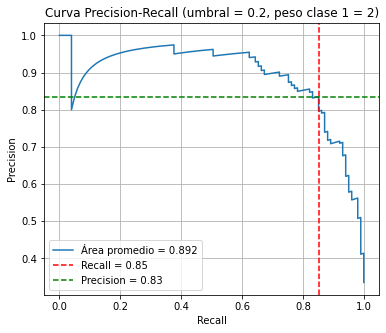

In [31]:

cat_cols = ["variedad", "sensor_id", "momento_dia"]


peso_clase_defectuosa = 2   
class_weights = [1.0, peso_clase_defectuosa]

modelo_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric="F1",
    random_seed=42,
    verbose=0,
    class_weights=class_weights
)


modelo_cb.fit(X_train, y_train, cat_features=cat_cols)


y_prob = modelo_cb.predict_proba(X_test)[:, 1]


umbral = 0.20 


y_pred = (y_prob >= umbral).astype(int)


reporte = classification_report(y_test, y_pred, output_dict=True)
precision_1 = reporte['1']['precision']
recall_1 = reporte['1']['recall']
f1_1 = reporte['1']['f1-score']

print(f"✅ Resultados CatBoost (clase defectuosa = 1, umbral = {umbral}, peso = {peso_clase_defectuosa})\n")
print(f"Precision: {precision_1:.3f}")
print(f"Recall:    {recall_1:.3f}")
print(f"F1-score:  {f1_1:.3f}")

# Curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"Área promedio = {ap:.3f}")
plt.axvline(x=recall_1, color="r", linestyle="--", label=f"Recall = {recall_1:.2f}")
plt.axhline(y=precision_1, color="g", linestyle="--", label=f"Precision = {precision_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (umbral = {umbral}, peso clase 1 = {peso_clase_defectuosa})")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
print(X_train.columns.tolist())

['humedad_mean', 'humedad_std', 'humedad_min', 'humedad_max', 'temp_mean', 'temp_std', 'temp_min', 'temp_max', 'variedad', 'sensor_id', 'humedad_range', 'temp_range', 'humedad_p25', 'humedad_p75', 'temp_p25', 'temp_p75', 'duracion_horas', 'hora_inicio', 'momento_dia', 'slope_temp', 'slope_hum']


# Versión 2

In [33]:
def resumir_tachadas_v2(df):
    df = df.sort_values(["ID_tachada", "timestamp"])


    resumen = df.groupby("ID_tachada").agg(
        humedad_mean=("HUMEDAD", "mean"),
        humedad_std=("HUMEDAD", "std"),
        humedad_min=("HUMEDAD", "min"),
        humedad_max=("HUMEDAD", "max"),
        temp_mean=("TEMPERATURA", "mean"),
        temp_std=("TEMPERATURA", "std"),
        temp_min=("TEMPERATURA", "min"),
        temp_max=("TEMPERATURA", "max"),
        timestamp_min=("timestamp", "min"),
        timestamp_max=("timestamp", "max"),
        variedad=("Variedad", "first"),
        planta=("planta", "first"),
        sensor_id=("sensor_id", "first"),
        año=("año", "first"),
        descartar=("DESCARTAR", "first")
    ).reset_index()

    # Rangos
    resumen["humedad_range"] = resumen["humedad_max"] - resumen["humedad_min"]
    resumen["temp_range"] = resumen["temp_max"] - resumen["temp_min"]

    # Percentiles
    resumen["humedad_p25"] = df.groupby("ID_tachada")["HUMEDAD"].quantile(0.25).values
    resumen["humedad_p75"] = df.groupby("ID_tachada")["HUMEDAD"].quantile(0.75).values
    resumen["temp_p25"] = df.groupby("ID_tachada")["TEMPERATURA"].quantile(0.25).values
    resumen["temp_p75"] = df.groupby("ID_tachada")["TEMPERATURA"].quantile(0.75).values

    # Duración total
    resumen["duracion_horas"] = (
        (resumen["timestamp_max"] - resumen["timestamp_min"]).dt.total_seconds() / 3600
    )

    # Momento del día
    resumen["hora_inicio"] = resumen["timestamp_min"].dt.hour
    condiciones = [
        resumen["hora_inicio"].between(6, 12),
        resumen["hora_inicio"].between(12, 18),
        resumen["hora_inicio"].between(18, 24),
        resumen["hora_inicio"].between(0, 6)
    ]
    categorias = ["mañana", "tarde", "noche", "madrugada"]
    resumen["momento_dia"] = np.select(condiciones, categorias, default="desconocido")

    # Pendientes
    def slope(grupo, col):
        if len(grupo) > 1:
            return (grupo[col].iloc[-1] - grupo[col].iloc[0]) / (
                (grupo["timestamp"].iloc[-1] - grupo["timestamp"].iloc[0]).total_seconds() + 1e-9
            )
        else:
            return 0

    resumen["slope_temp"] = df.groupby("ID_tachada").apply(slope, "TEMPERATURA").values
    resumen["slope_hum"] = df.groupby("ID_tachada").apply(slope, "HUMEDAD").values


    ventana_ini = resumen["timestamp_min"] + pd.Timedelta(minutes=30)
    ventana_fin = resumen["timestamp_max"] - pd.Timedelta(minutes=30)

    
    for col in [
        "humedad_mean_30ini", "humedad_std_30ini",
        "temp_mean_30ini", "temp_std_30ini",
        "humedad_mean_30fin", "humedad_std_30fin",
        "temp_mean_30fin", "temp_std_30fin"
    ]:
        resumen[col] = np.nan

    # Calcular stats por ID_tachada
    for idx, row in resumen.iterrows():
        id_tach = row["ID_tachada"]
        df_tach = df[df["ID_tachada"] == Primeros 30 minutos
        df_ini = df_tach[df_tach["timestamp"] <= ventana_ini.iloc[idx]]
        if len(df_ini) > 1:
            resumen.at[idx, "humedad_mean_30ini"] = df_ini["HUMEDAD"].mean()
            resumen.at[idx, "humedad_std_30ini"] = df_ini["HUMEDAD"].std()
            resumen.at[idx, "temp_mean_30ini"] = df_ini["TEMPERATURA"].mean()
            resumen.at[idx, "temp_std_30ini"] = df_ini["TEMPERATURA"].std()
        else:
            resumen.at[idx, "humedad_mean_30ini"] = row["humedad_mean"]
            resumen.at[idx, "temp_mean_30ini"] = row["temp_mean"]

        # Últimos 30 minuto
        df_fin = df_tach[df_tach["timestamp"] >= ventana_fin.iloc[idx]]
        if len(df_fin) > 1:
            resumen.at[idx, "humedad_mean_30fin"] = df_fin["HUMEDAD"].mean()
            resumen.at[idx, "humedad_std_30fin"] = df_fin["HUMEDAD"].std()
            resumen.at[idx, "temp_mean_30fin"] = df_fin["TEMPERATURA"].mean()
            resumen.at[idx, "temp_std_30fin"] = df_fin["TEMPERATURA"].std()
        else:
            resumen.at[idx, "humedad_mean_30fin"] = row["humedad_mean"]
            resumen.at[idx, "temp_mean_30fin"] = row["temp_mean"]

    # Diferencias
    resumen["diff_temp_ini_fin"] = resumen["temp_mean_30fin"] - resumen["temp_mean_30ini"]
    resumen["diff_hum_ini_fin"] = resumen["humedad_mean_30fin"] - resumen["humedad_mean_30ini"]

    return resumen

In [34]:
resumen_train2 = resumir_tachadas_v2(df_train)
resumen_test2  = resumir_tachadas_v2(df_test)

X_train2 = resumen_train2.drop(columns=["descartar", "ID_tachada", "planta", "año", 
                                        "timestamp_min", "timestamp_max"], errors="ignore")
y_train2 = resumen_train2["descartar"]

X_test2 = resumen_test2.drop(columns=["descartar", "ID_tachada", "planta", "año", 
                                      "timestamp_min", "timestamp_max"], errors="ignore")
y_test2 = resumen_test2["descartar"]

C:\Users\Usuario\AppData\Local\Temp/ipykernel_22932/1627382416.py:60: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen["slope_temp"] = df.groupby("ID_tachada").apply(slope, "TEMPERATURA").values
C:\Users\Usuario\AppData\Local\Temp/ipykernel_22932/1627382416.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen["slope_hum"] = df.groupby("ID_tachada").apply(slope, "HUMEDAD").values
C:\Users\Usuario\AppData\

In [35]:
cat_cols = ["variedad", "sensor_id", "momento_dia"]
for col in cat_cols:
    X_train2[col] = X_train2[col].astype("category")
    X_test2[col] = X_test2[col].astype("category")

In [39]:
for col in X_train2.columns:
    print(col)

humedad_mean
humedad_std
humedad_min
humedad_max
temp_mean
temp_std
temp_min
temp_max
variedad
sensor_id
humedad_range
temp_range
humedad_p25
humedad_p75
temp_p25
temp_p75
duracion_horas
hora_inicio
momento_dia
slope_temp
slope_hum
humedad_mean_30ini
humedad_std_30ini
temp_mean_30ini
temp_std_30ini
humedad_mean_30fin
humedad_std_30fin
temp_mean_30fin
temp_std_30fin
diff_temp_ini_fin
diff_hum_ini_fin


In [42]:
X_train2.columns[8]

'variedad'

In [43]:

X_train2["variedad"] = X_train2["variedad"].fillna("MERÍN").astype(str)
X_test2["variedad"]  = X_test2["variedad"].fillna("MERÍN").astype(str)

X_train2["sensor_id"] = X_train2["sensor_id"].astype(str).fillna("UNKNOWN")
X_test2["sensor_id"]  = X_test2["sensor_id"].astype(str).fillna("UNKNOWN")

X_train2["momento_dia"] = X_train2["momento_dia"].astype(str).fillna("UNKNOWN")
X_test2["momento_dia"]  = X_test2["momento_dia"].astype(str).fillna("UNKNOWN")

cat_cols = ["variedad", "sensor_id", "momento_dia"]

In [44]:

cat_cols = ["variedad", "sensor_id", "momento_dia"]

peso_clase_defectuosa = 2
class_weights = [1.0, peso_clase_defectuosa]


modelo_cb21 = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric="F1",
    random_seed=42,
    verbose=0,
    class_weights=class_weights
)

# Entrenamiento
modelo_cb21.fit(X_train2, y_train2, cat_features=cat_cols)



✅ modelo_cb21 entrenado correctamente



🔍 Resultados modelo_cb21 (umbral = 0.2, peso = 2)
Precision: 0.830
Recall:    0.822
F1-score:  0.826


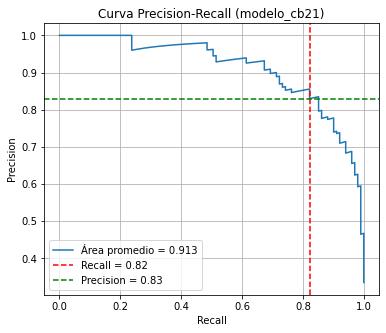

In [45]:

y_prob = modelo_cb21.predict_proba(X_test2)[:, 1]

umbral = 0.20
y_pred = (y_prob >= umbral).astype(int)


reporte = classification_report(y_test2, y_pred, output_dict=True)

precision_1 = reporte['1']['precision']
recall_1 = reporte['1']['recall']
f1_1 = reporte['1']['f1-score']

print(f"\n🔍 Resultados modelo_cb21 (umbral = {umbral}, peso = {peso_clase_defectuosa})")
print(f"Precision: {precision_1:.3f}")
print(f"Recall:    {recall_1:.3f}")
print(f"F1-score:  {f1_1:.3f}")


precision, recall, thresholds = precision_recall_curve(y_test2, y_prob)
ap = average_precision_score(y_test2, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"Área promedio = {ap:.3f}")
plt.axvline(x=recall_1, color="r", linestyle="--", label=f"Recall = {recall_1:.2f}")
plt.axhline(y=precision_1, color="g", linestyle="--", label=f"Precision = {precision_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (modelo_cb21)")
plt.legend()
plt.grid(True)
plt.show()

In [49]:

prueba_reporte = X_train2.copy()
prueba_reporte["descartar"] = y_train2.values    


prueba_reporte["prob_predicha"] = modelo_cb21.predict_proba(X_train2)[:, 1]

umbral = 0.20
prueba_reporte["prediccion"] = (prueba_reporte["prob_predicha"] >= umbral).astype(int)

prueba_reporte["prediccion_correcta"] = (
    prueba_reporte["prediccion"] == prueba_reporte["descartar"]
).astype(int)


prueba_reporte.to_csv("prueba_reporte.csv", index=False, encoding="utf-8")


✅ Archivo prueba_reporte.csv generado correctamente


In [51]:
from IPython.display import FileLink
FileLink("prueba_reporte.csv")

C:\Users\Usuario\prueba_reporte.csv

In [52]:

prueba_reporte.to_excel("prueba_reporte.xlsx", index=False)

from IPython.display import FileLink, display
display(FileLink("prueba_reporte.xlsx"))

C:\Users\Usuario\AppData\Local\Temp/ipykernel_22932/2989344512.py:2: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.1' currently installed).
  prueba_reporte.to_excel("prueba_reporte.xlsx", index=False)


C:\Users\Usuario\prueba_reporte.xlsx

# Versión 3

In [57]:
def resumir_tachadas_v3(df):
    df = df.sort_values(["ID_tachada", "timestamp"])

    # ============================================
    # 1) RESUMEN ORIGINAL (v1)
    # ============================================
    resumen = df.groupby("ID_tachada").agg(
        humedad_mean=("HUMEDAD", "mean"),
        humedad_std=("HUMEDAD", "std"),
        humedad_min=("HUMEDAD", "min"),
        humedad_max=("HUMEDAD", "max"),
        temp_mean=("TEMPERATURA", "mean"),
        temp_std=("TEMPERATURA", "std"),
        temp_min=("TEMPERATURA", "min"),
        temp_max=("TEMPERATURA", "max"),
        timestamp_min=("timestamp", "min"),
        timestamp_max=("timestamp", "max"),
        variedad=("Variedad", "first"),
        planta=("planta", "first"),
        sensor_id=("sensor_id", "first"),
        año=("año", "first"),
        descartar=("DESCARTAR", "first")
    ).reset_index()

    # Rango
    resumen["humedad_range"] = resumen["humedad_max"] - resumen["humedad_min"]
    resumen["temp_range"] = resumen["temp_max"] - resumen["temp_min"]

    # Percentiles
    resumen["humedad_p25"] = df.groupby("ID_tachada")["HUMEDAD"].quantile(0.25).values
    resumen["humedad_p75"] = df.groupby("ID_tachada")["HUMEDAD"].quantile(0.75).values
    resumen["temp_p25"] = df.groupby("ID_tachada")["TEMPERATURA"].quantile(0.25).values
    resumen["temp_p75"] = df.groupby("ID_tachada")["TEMPERATURA"].quantile(0.75).values

    # Duración horas
    resumen["duracion_horas"] = (
        resumen["timestamp_max"] - resumen["timestamp_min"]
    ).dt.total_seconds() / 3600

    # Momento del día
    resumen["hora_inicio"] = resumen["timestamp_min"].dt.hour
    condiciones = [
        resumen["hora_inicio"].between(6, 12),
        resumen["hora_inicio"].between(12, 18),
        resumen["hora_inicio"].between(18, 24),
        resumen["hora_inicio"].between(0, 6)
    ]
    categorias = ["mañana", "tarde", "noche", "madrugada"]
    resumen["momento_dia"] = np.select(condiciones, categorias, default="desconocido")

    # Slope global
    def slope(grupo, col):
        if len(grupo) > 1:
            return (grupo[col].iloc[-1] - grupo[col].iloc[0]) / (
                (grupo["timestamp"].iloc[-1] - grupo["timestamp"].iloc[0]).total_seconds() + 1e-9
            )
        return 0

    resumen["slope_temp"] = df.groupby("ID_tachada").apply(slope, "TEMPERATURA").values
    resumen["slope_hum"] = df.groupby("ID_tachada").apply(slope, "HUMEDAD").values

    # Funciones internas
    def count_crossings(series, thr):
        return np.sum((series.shift(1) < thr) & (series >= thr))

    def count_shocks(series, delta):
        return np.sum(series.diff().abs() > delta)

    def time_in_zone(df_tach, col, thr):
        return np.sum(df_tach[col] > thr)

    def segmented_slope(series):
        n = len(series)
        if n < 4:
            return (0, 0)
        q1 = series.iloc[:n//4]
        q4 = series.iloc[-n//4:]
        slope_q1 = (q1.iloc[-1] - q1.iloc[0]) / (len(q1) + 1e-6)
        slope_q4 = (q4.iloc[-1] - q4.iloc[0]) / (len(q4) + 1e-6)
        return slope_q1, slope_q4

    nuevas_cols = [
        "temp_cross_35", "hum_cross_80",
        "temp_shocks_3", "hum_shocks_5",
        "temp_time_above_40", "hum_time_above_85",
        "slope_temp_Q1", "slope_temp_Q4",
        "slope_hum_Q1", "slope_hum_Q4",
        "drying_rate", "drop_ratio_temp", "drop_ratio_hum"
    ]
    for c in nuevas_cols:
        resumen[c] = np.nan

    for idx, row in resumen.iterrows():
        id_tach = row["ID_tachada"]
        df_tach = df[df["ID_tachada"] == id_tach].sort_values("timestamp")

        # Cruces
        resumen.at[idx, "temp_cross_35"] = count_crossings(df_tach["TEMPERATURA"], 35)
        resumen.at[idx, "hum_cross_80"] = count_crossings(df_tach["HUMEDAD"], 80)

        # Shocks
        resumen.at[idx, "temp_shocks_3"] = count_shocks(df_tach["TEMPERATURA"], 3)
        resumen.at[idx, "hum_shocks_5"] = count_shocks(df_tach["HUMEDAD"], 5)

        # Zona crítica
        resumen.at[idx, "temp_time_above_40"] = time_in_zone(df_tach, "TEMPERATURA", 40)
        resumen.at[idx, "hum_time_above_85"] = time_in_zone(df_tach, "HUMEDAD", 85)

        # Slopes segmentados
        st1, st4 = segmented_slope(df_tach["TEMPERATURA"])
        sh1, sh4 = segmented_slope(df_tach["HUMEDAD"])
        resumen.at[idx, "slope_temp_Q1"] = st1
        resumen.at[idx, "slope_temp_Q4"] = st4
        resumen.at[idx, "slope_hum_Q1"] = sh1
        resumen.at[idx, "slope_hum_Q4"] = sh4

        # Tasa real de secado
        try:
            resumen.at[idx, "drying_rate"] = (
                row["humedad_mean"] - row["humedad_min"]
            ) / (row["duracion_horas"] + 1e-6)
        except:
            resumen.at[idx, "drying_rate"] = np.nan

        # Drop ratio (inicio-fin global)
        resumen.at[idx, "drop_ratio_temp"] = row["temp_min"] / (row["temp_max"] + 1e-6)
        resumen.at[idx, "drop_ratio_hum"] = row["humedad_min"] / (row["humedad_max"] + 1e-6)

    return resumen

In [58]:
resumen_train3 = resumir_tachadas_v3(df_train)
resumen_test3 = resumir_tachadas_v3(df_test)

C:\Users\Usuario\AppData\Local\Temp/ipykernel_22932/4227598155.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen["slope_temp"] = df.groupby("ID_tachada").apply(slope, "TEMPERATURA").values
C:\Users\Usuario\AppData\Local\Temp/ipykernel_22932/4227598155.py:60: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen["slope_hum"] = df.groupby("ID_tachada").apply(slope, "HUMEDAD").values
C:\Users\Usuario\AppData\

🔍 Mejor umbral según Mutual Information: 38


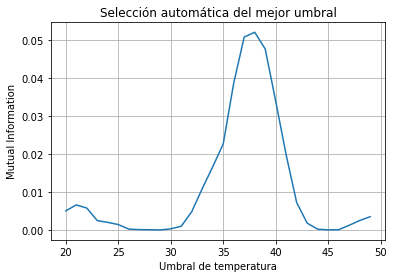

In [59]:
import numpy as np
from sklearn.metrics import mutual_info_score


umbrales = range(20, 50)
scores = []

for u in umbrales:
    cruzes = df_train.groupby("ID_tachada")["TEMPERATURA"].apply(
        lambda x: np.sum((x.shift(1) < u) & (x >= u))
    )
    scores.append(mutual_info_score(cruzes > 0, resumen_train3["descartar"]))

best_umbral = umbrales[np.argmax(scores)]


plt.plot(umbrales, scores)
plt.xlabel("Umbral de temperatura")
plt.ylabel("Mutual Information")
plt.title("Selección automática del mejor umbral")
plt.grid(True)
plt.show()

🔍 Mejor umbral de humedad según MI: 11


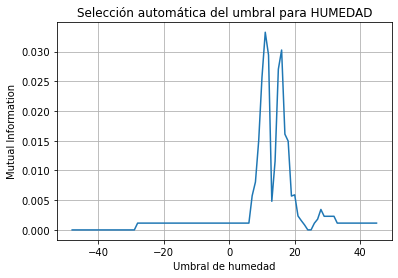

In [61]:
# Rango real de humedad basado en tus datos
min_h = int(df_train["HUMEDAD"].min())
max_h = int(df_train["HUMEDAD"].max())

umbrales_hum = np.arange(min_h, max_h + 1)

scores_hum = []

for u in umbrales_hum:
    cruzes_hum = df_train.groupby("ID_tachada")["HUMEDAD"].apply(
        lambda x: np.sum((x.shift(1) < u) & (x >= u))
    )
    scores_hum.append(mutual_info_score(cruzes_hum > 0, resumen_train3["descartar"]))

best_hum_umbral = umbrales_hum[np.argmax(scores_hum)]
print("🔍 Mejor umbral de humedad según MI:", best_hum_umbral)

plt.plot(umbrales_hum, scores_hum)
plt.xlabel("Umbral de humedad")
plt.ylabel("Mutual Information")
plt.title("Selección automática del umbral para HUMEDAD")
plt.grid(True)
plt.show()

In [16]:
def resumir_tachadas_v3(df):
    df = df.sort_values(["ID_tachada", "timestamp"])

    resumen = df.groupby("ID_tachada").agg(
        humedad_mean=("HUMEDAD", "mean"),
        humedad_std=("HUMEDAD", "std"),
        humedad_min=("HUMEDAD", "min"),
        humedad_max=("HUMEDAD", "max"),
        temp_mean=("TEMPERATURA", "mean"),
        temp_std=("TEMPERATURA", "std"),
        temp_min=("TEMPERATURA", "min"),
        temp_max=("TEMPERATURA", "max"),
        timestamp_min=("timestamp", "min"),
        timestamp_max=("timestamp", "max"),
        variedad=("Variedad", "first"),
        planta=("planta", "first"),
        sensor_id=("sensor_id", "first"),
        año=("año", "first"),
        descartar=("DESCARTAR", "first")
    ).reset_index()

    # Rango
    resumen["humedad_range"] = resumen["humedad_max"] - resumen["humedad_min"]
    resumen["temp_range"] = resumen["temp_max"] - resumen["temp_min"]

    # Percentiles
    resumen["humedad_p25"] = df.groupby("ID_tachada")["HUMEDAD"].quantile(0.25).values
    resumen["humedad_p75"] = df.groupby("ID_tachada")["HUMEDAD"].quantile(0.75).values
    resumen["temp_p25"] = df.groupby("ID_tachada")["TEMPERATURA"].quantile(0.25).values
    resumen["temp_p75"] = df.groupby("ID_tachada")["TEMPERATURA"].quantile(0.75).values

    # Duración del secado (en horas)
    resumen["duracion_horas"] = (
        resumen["timestamp_max"] - resumen["timestamp_min"]
    ).dt.total_seconds() / 3600

    # Momento del día
    resumen["hora_inicio"] = resumen["timestamp_min"].dt.hour
    condiciones = [
        resumen["hora_inicio"].between(6, 12),
        resumen["hora_inicio"].between(12, 18),
        resumen["hora_inicio"].between(18, 24),
        resumen["hora_inicio"].between(0, 6)
    ]
    categorias = ["mañana", "tarde", "noche", "madrugada"]
    resumen["momento_dia"] = np.select(condiciones, categorias, default="desconocido")

    # Slope global temperatura / humedad
    def slope(grupo, col):
        if len(grupo) > 1:
            return (grupo[col].iloc[-1] - grupo[col].iloc[0]) / (
                (grupo["timestamp"].iloc[-1] - grupo["timestamp"].iloc[0]).total_seconds() + 1e-9
            )
        return 0

    resumen["slope_temp"] = df.groupby("ID_tachada").apply(slope, "TEMPERATURA").values
    resumen["slope_hum"] = df.groupby("ID_tachada").apply(slope, "HUMEDAD").values


    # Umbral óptimo temperatura (Mutual Information)
    UMBRAL_TEMP      = 38

    # Umbral óptimo humedad (Mutual Information)
    UMBRAL_HUM       = 11

    # Umbral de humedad final esperada según negocio
    HUM_FINAL_BUENA  = 13

    def count_crossings(series, thr):
        # Cuenta cuántas veces la variable cruza el umbral desde abajo hacia arriba.
        return np.sum((series.shift(1) < thr) & (series >= thr))

    def count_shocks(series, delta):
        # Cuenta “saltos bruscos”: |Δ| > delta entre mediciones consecutivas.
        return np.sum(series.diff().abs() > delta)

    def time_in_zone(df_t, col, thr):
        # Cantidad de mediciones por encima de un umbral (tiempo en zona crítica).
        return np.sum(df_t[col] > thr)

    def segmented_slope(series):
        # Pendiente en 1er cuarto del proceso y último cuarto.
        n = len(series)
        if n < 4:
            return (0, 0)
        q1 = series.iloc[:n//4]
        q4 = series.iloc[-n//4:]
        slope_q1 = (q1.iloc[-1] - q1.iloc[0]) / (len(q1) + 1e-6)
        slope_q4 = (q4.iloc[-1] - q4.iloc[0]) / (len(q4) + 1e-6)
        return slope_q1, slope_q4

    # Lista de nuevas features
    nuevas_cols = [
        "temp_cross_38",      # Cruces ascendentes sobre 38°C (indicador de oscilación térmica peligrosa)
        "hum_cross_11",       # Cruces ascendentes sobre 11% humedad (zonas de re-humectación)
        "temp_shocks_3",      # Saltos bruscos de temperatura >3°C
        "hum_shocks_5",       # Saltos bruscos de humedad >5%
        "temp_time_above_38", # Cantidad de mediciones con temperatura >38°C
        "hum_time_above_11",  # Cantidad de mediciones con humedad >11%
        "slope_temp_Q1",      # Pendiente temprana de temperatura
        "slope_temp_Q4",      # Pendiente tardía de temperatura
        "slope_hum_Q1",       # Pendiente temprana de humedad
        "slope_hum_Q4",       # Pendiente tardía de humedad
        "drying_rate",        # Velocidad de secado promedio
        "drop_ratio_temp",    # temp_min/temp_max (indicador de estabilidad)
        "drop_ratio_hum",     # humedad_min/humedad_max (indicador de estabilidad)
        "hum_final_above_13"  # 1 si termina por encima de humedad 13%, 0 si no
    ]

    for c in nuevas_cols:
        resumen[c] = np.nan

    for idx, row in resumen.iterrows():
        id_tach = row["ID_tachada"]
        df_tach = df[df["ID_tachada"] == id_tach].sort_values("timestamp")

        # Cruces óptimos temperatura/humedad
        resumen.at[idx, "temp_cross_38"] = count_crossings(df_tach["TEMPERATURA"], UMBRAL_TEMP)
        resumen.at[idx, "hum_cross_11"]  = count_crossings(df_tach["HUMEDAD"], UMBRAL_HUM)

        # Shocks
        resumen.at[idx, "temp_shocks_3"] = count_shocks(df_tach["TEMPERATURA"], 3)
        resumen.at[idx, "hum_shocks_5"]  = count_shocks(df_tach["HUMEDAD"], 5)

        # Tiempo en zona crítica (basado en umbrales óptimos)
        resumen.at[idx, "temp_time_above_38"] = time_in_zone(df_tach, "TEMPERATURA", UMBRAL_TEMP)
        resumen.at[idx, "hum_time_above_11"]  = time_in_zone(df_tach, "HUMEDAD", UMBRAL_HUM)

        # Slopes segmentados
        st1, st4 = segmented_slope(df_tach["TEMPERATURA"])
        sh1, sh4 = segmented_slope(df_tach["HUMEDAD"])
        resumen.at[idx, "slope_temp_Q1"] = st1
        resumen.at[idx, "slope_temp_Q4"] = st4
        resumen.at[idx, "slope_hum_Q1"] = sh1
        resumen.at[idx, "slope_hum_Q4"] = sh4

        # Velocidad promedio de secado
        resumen.at[idx, "drying_rate"] = (
            row["humedad_mean"] - row["humedad_min"]
        ) / (row["duracion_horas"] + 1e-6)

        # Relación entre mínimos y máximos
        resumen.at[idx, "drop_ratio_temp"] = row["temp_min"] / (row["temp_max"] + 1e-6)
        resumen.at[idx, "drop_ratio_hum"]  = row["humedad_min"] / (row["humedad_max"] + 1e-6)

        # Indicador de si terminó por encima de humedad 13%
        resumen.at[idx, "hum_final_above_13"] = int(row["humedad_min"] > HUM_FINAL_BUENA)

    return resumen

In [17]:
resumen_train3 = resumir_tachadas_v3(df_train)
resumen_test3  = resumir_tachadas_v3(df_test)

print("Shapes:", resumen_train3.shape, resumen_test3.shape)

C:\Users\Usuario\AppData\Local\Temp/ipykernel_3568/158588183.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen["slope_temp"] = df.groupby("ID_tachada").apply(slope, "TEMPERATURA").values
C:\Users\Usuario\AppData\Local\Temp/ipykernel_3568/158588183.py:60: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen["slope_hum"] = df.groupby("ID_tachada").apply(slope, "HUMEDAD").values
C:\Users\Usuario\AppData\Loca

Shapes: (1201, 41) (301, 41)


In [18]:
X_train3 = resumen_train3.drop(columns=["descartar"])
y_train3 = resumen_train3["descartar"]

X_test3 = resumen_test3.drop(columns=["descartar"])
y_test3 = resumen_test3["descartar"]

In [19]:
cols_drop = ["ID_tachada", "planta", "año", "tirada_fecha", "timestamp_min", "timestamp_max"]

X_train3 = X_train3.drop(columns=cols_drop, errors="ignore")
X_test3  = X_test3.drop(columns=cols_drop, errors="ignore")

In [20]:
X_train3["sensor_id"] = X_train3["sensor_id"].astype(str)
X_test3["sensor_id"]  = X_test3["sensor_id"].astype(str)

cat_cols = ["variedad", "sensor_id", "momento_dia"]

for col in cat_cols:
    X_train3[col] = X_train3[col].astype("category")
    X_test3[col]  = X_test3[col].astype("category")

In [21]:
X_train3["variedad"] = X_train3["variedad"].fillna("MERÍN")
X_test3["variedad"]  = X_test3["variedad"].fillna("MERÍN")

In [22]:
from catboost import CatBoostClassifier

modelo_cb22 = CatBoostClassifier(
    iterations=350,
    learning_rate=0.05,
    depth=5,
    eval_metric="F1",
    random_seed=42,
    verbose=100,
    class_weights=[1, 2.5]      
)

modelo_cb22.fit(X_train3, y_train3, cat_features=cat_cols)


0:	learn: 0.6850394	total: 17.1ms	remaining: 5.97s
100:	learn: 0.8964074	total: 1.5s	remaining: 3.69s
200:	learn: 0.9658148	total: 2.94s	remaining: 2.18s
300:	learn: 0.9937684	total: 4.43s	remaining: 721ms
349:	learn: 0.9973753	total: 5.14s	remaining: 0us
✅ Modelo modelo_cb22 (v3) entrenado correctamente.



⚡ RESULTADOS — modelo_cb22 (v3) con umbral = 0.2
Precision clase 1:  0.803
Recall clase 1:     0.931
F1-score clase 1:   0.862
Accuracy:           0.9
Pseudo-R²:          0.553


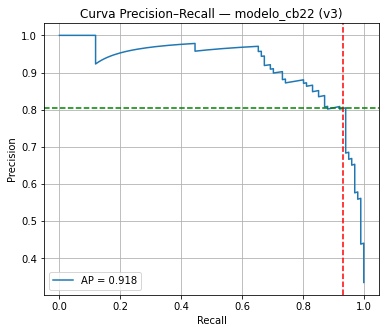

In [23]:

y_prob3 = modelo_cb22.predict_proba(X_test3)[:, 1]


umbral = 0.2
y_pred3 = (y_prob3 >= umbral).astype(int)

reporte3 = classification_report(y_test3, y_pred3, output_dict=True)

precision_1 = reporte3['1']['precision']
recall_1    = reporte3['1']['recall']
f1_1        = reporte3['1']['f1-score']


accuracy = accuracy_score(y_test3, y_pred3)
r2       = r2_score(y_test3, y_pred3)  

print("\n⚡ RESULTADOS — modelo_cb22 (v3) con umbral =", umbral)
print("Precision clase 1: ", round(precision_1, 3))
print("Recall clase 1:    ", round(recall_1, 3))
print("F1-score clase 1:  ", round(f1_1, 3))
print("Accuracy:          ", round(accuracy, 3))
print("Pseudo-R²:         ", round(r2, 3))


precision_curve, recall_curve, thresholds = precision_recall_curve(y_test3, y_prob3)
ap = average_precision_score(y_test3, y_prob3)

plt.figure(figsize=(6,5))
plt.plot(recall_curve, precision_curve, label=f"AP = {ap:.3f}")
plt.axvline(recall_1, color="red", linestyle="--")
plt.axhline(precision_1, color="green", linestyle="--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall — modelo_cb22 (v3)")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
y_prob3 = modelo_cb22.predict_proba(X_test3)[:, 1]

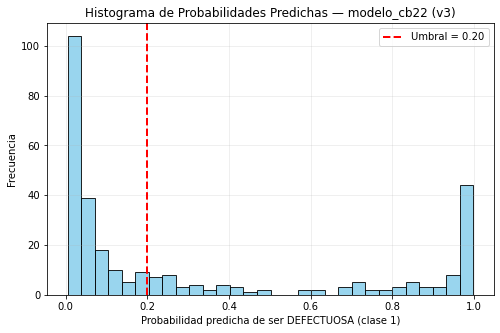

In [25]:
plt.figure(figsize=(8,5))

plt.hist(
    y_prob3,
    bins=30,
    color="skyblue",
    edgecolor="black",
    alpha=0.85
)

plt.axvline(0.20, color="red", linestyle="--", linewidth=2, label="Umbral = 0.20")

plt.title("Histograma de Probabilidades Predichas — modelo_cb22 (v3)")
plt.xlabel("Probabilidad predicha de ser DEFECTUOSA (clase 1)")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

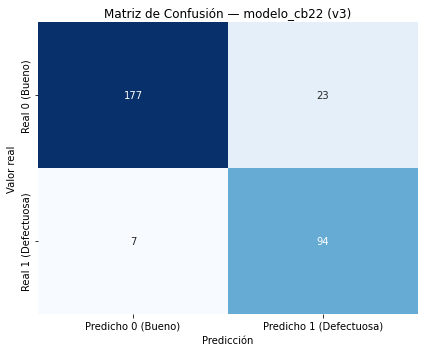


Matriz de confusión (valores):
[[177  23]
 [  7  94]]


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test3, y_pred3)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Predicho 0 (Bueno)", "Predicho 1 (Defectuosa)"],
    yticklabels=["Real 0 (Bueno)", "Real 1 (Defectuosa)"]
)

plt.title("Matriz de Confusión — modelo_cb22 (v3)")
plt.ylabel("Valor real")
plt.xlabel("Predicción")
plt.tight_layout()
plt.show()

print("\nMatriz de confusión (valores):")
print(cm)

In [27]:
from catboost import cv, Pool

pool = Pool(X_train3, y_train3, cat_features=cat_cols)

params = {
    "iterations": 350,
    "depth": 5,
    "learning_rate": 0.05,
    "class_weights": [1, 2.5],
    "loss_function": "Logloss",
    "eval_metric": "F1",
    "random_seed": 42
}

cv_results = cv(
    pool=pool,
    params=params,
    fold_count=5,
    verbose=False
)

cv_results.tail()

Training on fold [0/5]

bestTest = 0.834845735
bestIteration = 197

Training on fold [1/5]

bestTest = 0.8545454545
bestIteration = 233

Training on fold [2/5]

bestTest = 0.8064516129
bestIteration = 148

Training on fold [3/5]

bestTest = 0.8556149733
bestIteration = 152

Training on fold [4/5]

bestTest = 0.7918968692
bestIteration = 24



,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
345,345,0.798781,0.037547,0.997946,0.001839,0.381044,0.043230,0.067354,0.004176
346,346,0.800990,0.037689,0.997946,0.001839,0.381163,0.043542,0.067044,0.004171
347,347,0.800990,0.037689,0.998110,0.001582,0.381573,0.043739,0.066668,0.004023
348,348,0.803483,0.032591,0.998110,0.001582,0.381946,0.043360,0.066297,0.003976
349,349,0.801274,0.032639,0.998110,0.001582,0.382378,0.043284,0.065951,0.003901


Para verificar que el modelo no estuviera sobreajustado, aplicamos validación cruzada de 5 pliegues.
La validación cruzada consiste en dividir el conjunto de entrenamiento en 5 particiones (‘pliegues’). En cada iteración, el modelo se entrena en 4 pliegues y se evalúa en el pliegue restante; el proceso se repite 5 veces, rotando la partición utilizada como validación.
Este procedimiento permite evaluar el rendimiento del modelo en múltiples subconjuntos de datos no vistos, lo cual es fundamental para detectar overfitting.

En nuestro caso, el F1-score obtenido en los 5 pliegues fue muy estable, variando entre 0.79 y 0.86, con un promedio de aproximadamente 0.83. Estos resultados son muy similares al desempeño final del modelo sobre el conjunto de test (F1 = 0.86), lo cual indica que el modelo generaliza correctamente y que no existe evidencia de sobreajuste.

In [28]:
modelo_cb22.save_model("modelo_tachadas.cbm")

In [29]:
import os
os.getcwd()

'C:\\Users\\Usuario'